In [1]:
import itertools as it
import os

from cliffs_delta import cliffs_delta
from iterpop import iterpop as ip
import matplotlib as mpl
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp

from pylib import describe_effect


In [2]:
# prints metadata about notebook runtime
nbm.print_metadata()


context: ci
hostname: fv-az661-842
interpreter: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
nbcellexec: null
nbname: reconstructed-tree-phylometrics
nbpath: /home/runner/work/hstrat-evolutionary-inference/hstrat-evolutionary-inference/binder/simple-splayed/reconstructed-tree-phylometrics.ipynb
revision: null
session: 28d5d3ad-e604-4ffb-b6c8-a6091efbcdf4
timestamp: 2024-11-21T01:35:58Z00:00


IPython==8.13.0
keyname==0.5.2
yaml==6.0
iterpop==0.4.1
matplotlib==3.7.1
nbmetalog==0.2.6
numpy==1.21.6
pandas==1.3.5
scipy==1.7.3
seaborn==0.12.1
teeplot==1.0.1
re==2.2.1
comm==0.2.2
logging==0.5.1.2
psutil==5.9.8
zmq==24.0.1
json==2.0.9
ipykernel==6.29.3


In [3]:
df = pd.read_csv("https://osf.io/xd95a/download")
dfdigest = np.bitwise_xor.reduce(
    pd.util.hash_pandas_object(df),
)
print("{:x}".format(dfdigest))
df


d5fa12f6738c655


a  epoch                  mut_distn  \
0       collapsed-phylogeny      7  np.random.standard_normal   
1       collapsed-phylogeny      7  np.random.standard_normal   
2       collapsed-phylogeny      7  np.random.standard_normal   
3       collapsed-phylogeny      7  np.random.standard_normal   
4       collapsed-phylogeny      7  np.random.standard_normal   
...                     ...    ...                        ...   
104995   reconstructed-tree      2  np.random.standard_normal   
104996   reconstructed-tree      2  np.random.standard_normal   
104997   reconstructed-tree      2  np.random.standard_normal   
104998   reconstructed-tree      2  np.random.standard_normal   
104999   reconstructed-tree      2  np.random.standard_normal   

        num_generations  num_islands  num_niches  p_island_migration  \
0                 32768         1024           4                0.01   
1                 32768         1024           4                0.01   
2                 32768         1024           4                0.01   
3                 32768         1024           4                0.01   
4                 32768         1024           4                0.01   
...                 ...          ...         ...                 ...   
104995            32768            1           4                0.01   
104996            32768            1           4                0.01   
104997            32768            1           4                0.01   
104998            32768            1           4                0.01   
104999            32768            1           4                0.01   

        p_niche_invasion  population_size  replicate  ...  \
0           3.051758e-06            32768         20  ...   
1           3.051758e-06            32768          4  ...   
2           3.051758e-06            32768         41  ...   
3           3.051758e-06            32768         47  ...   
4           3.051758e-06            32768         15  ...   
...                  ...              ...        ...  ...   
104995      3.051758e-08            32768         10  ...   
104996      3.051758e-08            32768         16  ...   
104997      3.051758e-08            32768          1  ...   
104998      3.051758e-08            32768         10  ...   
104999      3.051758e-08            32768         36  ...   

        variance_pairwise_distance  variance_pairwise_distance_branch_only  \
0                        31.886538                               31.886538   
1                        28.357566                               28.357566   
2                        28.516943                               28.516943   
3                        30.233129                               30.233129   
4                        29.675131                               29.675131   
...                            ...                                     ...   
104995                   28.560595                               28.560595   
104996                   20.627240                               20.627240   
104997                  114.169456                              114.169456   
104998                   36.528638                               36.528638   
104999                   34.498647                               34.498647   

        mrca_depth  sackin_index mean_evolutionary_distinctiveness  \
0                1        609638                         78.882446   
1                1        588616                         81.707306   
2                0        592371                         83.217377   
3                0        586736                         86.538544   
4                1        600764                         76.277557   
...            ...           ...                               ...   
104995           1          3547                         99.163609   
104996           0          3331                       1893.146789   
104997           1        821866                          5.744125   
104998    

In [4]:
# filter out incomplete sets of replicates
df1 = df[
    df["a"] == "reconstructed-tree"
].groupby(
    [
        'epoch',
        'mut_distn',
        'num_islands',
        'num_niches',
        'p_island_migration',
        'p_niche_invasion',
        'population_size',
        'tournament_size',
        'treatment',
        'a',
        'resolution',
        'subsampling-fraction',
        'trie-postprocess',
    ],
    dropna=False,
).filter(
    lambda x: len(x) == 50,
).reset_index(drop=True)

df1["a"].unique()


array(['reconstructed-tree'], dtype=object)

In [5]:
# filter out incomplete sets of replicates
df2 = df[
    df["a"] == "collapsed-phylogeny"
].groupby(
    [
        'epoch',
        'mut_distn',
        'num_islands',
        'num_niches',
        'p_island_migration',
        'p_niche_invasion',
        'population_size',
        'tournament_size',
        'treatment',
        'a',
    ],
    dropna=False,
).filter(
    lambda x: len(x) == 50,
).reset_index(drop=True)

df2["a"].unique()


array(['collapsed-phylogeny'], dtype=object)

In [6]:
df = pd.concat([df1, df2], ignore_index=True)
df


a  epoch              mut_distn  num_generations  \
0        reconstructed-tree      7  np.random.exponential            32768   
1        reconstructed-tree      7  np.random.exponential            32768   
2        reconstructed-tree      7  np.random.exponential            32768   
3        reconstructed-tree      7  np.random.exponential            32768   
4        reconstructed-tree      7  np.random.exponential            32768   
...                     ...    ...                    ...              ...   
104995  collapsed-phylogeny      2  np.random.exponential            32768   
104996  collapsed-phylogeny      2  np.random.exponential            32768   
104997  collapsed-phylogeny      2  np.random.exponential            32768   
104998  collapsed-phylogeny      2  np.random.exponential            32768   
104999  collapsed-phylogeny      2  np.random.exponential            32768   

        num_islands  num_niches  p_island_migration  p_niche_invasion  \
0              1024           4                0.01      3.051758e-08   
1              1024           4                0.01      3.051758e-08   
2              1024           4                0.01      3.051758e-08   
3              1024           4                0.01      3.051758e-08   
4              1024           4                0.01      3.051758e-08   
...             ...         ...                 ...               ...   
104995         1024           4                0.01      3.051758e-06   
104996         1024           4                0.01      3.051758e-06   
104997         1024           4                0.01      3.051758e-06   
104998         1024           4                0.01      3.051758e-06   
104999         1024           4                0.01      3.051758e-06   

        population_size  replicate  ...  variance_pairwise_distance  \
0                 32768         46  ...                   30.592668   
1                 32768         30  ...                   25.488540   
2                 32768         32  ...                   16.790542   
3                 32768          1  ...                   25.969854   
4                 32768         17  ...                   20.596500   
...                 ...        ...  ...                         ...   
104995            32768         35  ...                   31.222858   
104996            32768         30  ...                   33.379170   
104997            32768         49  ...                   36.683984   
104998            32768         42  ...                   27.494275   
104999            32768         13  ...                   30.929621   

        variance_pairwise_distance_branch_only  mrca_depth  sackin_index  \
0                                    30.592668           0        601771   
1                                    25.488540           0        576666   
2                                    16.790542           0          3177   
3                                    25.969854           0        579202   
4                                    20.596500           0          3242   
...                                        ...         ...           ...   
104995                               31.222858           0        597571   
104996                               33.379170           0        593800   
104997                               36.683984           0        600262   
104998                               27.494275           0        580657   
104999                               30.929621           0        585228   

       mean_evolutionary_distinctiveness sum_evolutionary_distinctiveness  \
0                             118.941956                     3.897490e+06   
1                             123.441128                     4.044919e+06   
2                            8880.562691                     2.903944e+06   
3                             122.678925                     4.019943e+06   
4                           10902.110092                     

In [7]:
# phylometrics whittled down to descriptive, non-redundant set
phylometrics = [
    #     'diversity',
    "colless_like_index",
    #     'average_depth',
    #     'average_origin_time',
    #     'average_origin_time_normalized',
    #     'max_depth',
    "mean_pairwise_distance",
    #     'mean_pairwise_distance_branch_only',
    #     'num_active',
    # "num_ancestors",
    "sum_distance",
    #     'num_outside',
    #     'num_roots',
    #     'num_taxa',
    #     'phylogenetic_diversity',
    #     'sum_pairwise_distance',
    #     'sum_pairwise_distance_branch_only',
    #     'total_orgs',
    #     'tree_size',
    #     'variance_pairwise_distance',
    #     'variance_pairwise_distance_branch_only',
    #     'mrca_depth',
    #     'sackin_index',
    "mean_evolutionary_distinctiveness",
    #     'sum_evolutionary_distinctiveness',
    #     'variance_evolutionary_distinctiveness',
]


In [8]:
methodological_variables = [
    "resolution",
]


In [9]:
evolutionary_variables = [
    "num_islands",
    "num_niches",
    "tournament_size",
    "p_niche_invasion",
]


In [10]:
sensitivity_analysis_variables = [
    "epoch",
    "mut_distn",
]


In [11]:
fixed_variables = [
    "num_generations",  # homogeneous (num generations per epoch)
    "p_island_migration",  # homogeneous
    "population_size",  # homogeneous
    "subsampling-fraction",  # only use 1.0
    "trie-postprocess",  # just use naive postprocessing for now
]


In [12]:
# ensure fixed variables
df = df[
    (df["p_island_migration"] == 0.01)
    & ((df["subsampling-fraction"] == 1.0) | df["subsampling-fraction"].isna())
    & ((df["trie-postprocess"] == "naive") | df["trie-postprocess"].isna())
].copy()

for fixed_variable in fixed_variables:
    assert len(df[fixed_variable].dropna().unique()) == 1

df


a  epoch              mut_distn  num_generations  \
3        reconstructed-tree      7  np.random.exponential            32768   
13       reconstructed-tree      7  np.random.exponential            32768   
17       reconstructed-tree      7  np.random.exponential            32768   
36       reconstructed-tree      7  np.random.exponential            32768   
39       reconstructed-tree      7  np.random.exponential            32768   
...                     ...    ...                    ...              ...   
104995  collapsed-phylogeny      2  np.random.exponential            32768   
104996  collapsed-phylogeny      2  np.random.exponential            32768   
104997  collapsed-phylogeny      2  np.random.exponential            32768   
104998  collapsed-phylogeny      2  np.random.exponential            32768   
104999  collapsed-phylogeny      2  np.random.exponential            32768   

        num_islands  num_niches  p_island_migration  p_niche_invasion  \
3              1024           4                0.01      3.051758e-08   
13             1024           4                0.01      3.051758e-08   
17             1024           4                0.01      3.051758e-08   
36             1024           4                0.01      3.051758e-08   
39             1024           4                0.01      3.051758e-08   
...             ...         ...                 ...               ...   
104995         1024           4                0.01      3.051758e-06   
104996         1024           4                0.01      3.051758e-06   
104997         1024           4                0.01      3.051758e-06   
104998         1024           4                0.01      3.051758e-06   
104999         1024           4                0.01      3.051758e-06   

        population_size  replicate  ...  variance_pairwise_distance  \
3                 32768          1  ...                   25.969854   
13                32768         36  ...                   31.746852   
17                32768         28  ...                   21.621329   
36                32768         29  ...                   22.699686   
39                32768         13  ...                   28.435546   
...                 ...        ...  ...                         ...   
104995            32768         35  ...                   31.222858   
104996            32768         30  ...                   33.379170   
104997            32768         49  ...                   36.683984   
104998            32768         42  ...                   27.494275   
104999            32768         13  ...                   30.929621   

        variance_pairwise_distance_branch_only  mrca_depth  sackin_index  \
3                                    25.969854           0        579202   
13                                   31.746852           0        588384   
17                                   21.621329           0        565754   
36                                   22.699686           1        571302   
39                                   28.435546           0        579177   
...                                        ...         ...           ...   
104995                               31.222858           0        597571   
104996                               33.379170           0        593800   
104997                               36.683984           0        600262   
104998                               27.494275           0        580657   
104999                               30.929621           0        585228   

       mean_evolutionary_distinctiveness sum_evolutionary_distinctiveness  \
3                             122.678925                        4019943.0   
13                            127.564987                        4180049.5   
17                            135.647598                        4444900.5   
36                            109.768127                        3596882.0   
39                            122.617172                     

In [13]:
# exclude extraneous variable values
df = df[(df["a"] != "consolidated-phylogeny")].copy()

df


a  epoch              mut_distn  num_generations  \
3        reconstructed-tree      7  np.random.exponential            32768   
13       reconstructed-tree      7  np.random.exponential            32768   
17       reconstructed-tree      7  np.random.exponential            32768   
36       reconstructed-tree      7  np.random.exponential            32768   
39       reconstructed-tree      7  np.random.exponential            32768   
...                     ...    ...                    ...              ...   
104995  collapsed-phylogeny      2  np.random.exponential            32768   
104996  collapsed-phylogeny      2  np.random.exponential            32768   
104997  collapsed-phylogeny      2  np.random.exponential            32768   
104998  collapsed-phylogeny      2  np.random.exponential            32768   
104999  collapsed-phylogeny      2  np.random.exponential            32768   

        num_islands  num_niches  p_island_migration  p_niche_invasion  \
3              1024           4                0.01      3.051758e-08   
13             1024           4                0.01      3.051758e-08   
17             1024           4                0.01      3.051758e-08   
36             1024           4                0.01      3.051758e-08   
39             1024           4                0.01      3.051758e-08   
...             ...         ...                 ...               ...   
104995         1024           4                0.01      3.051758e-06   
104996         1024           4                0.01      3.051758e-06   
104997         1024           4                0.01      3.051758e-06   
104998         1024           4                0.01      3.051758e-06   
104999         1024           4                0.01      3.051758e-06   

        population_size  replicate  ...  variance_pairwise_distance  \
3                 32768          1  ...                   25.969854   
13                32768         36  ...                   31.746852   
17                32768         28  ...                   21.621329   
36                32768         29  ...                   22.699686   
39                32768         13  ...                   28.435546   
...                 ...        ...  ...                         ...   
104995            32768         35  ...                   31.222858   
104996            32768         30  ...                   33.379170   
104997            32768         49  ...                   36.683984   
104998            32768         42  ...                   27.494275   
104999            32768         13  ...                   30.929621   

        variance_pairwise_distance_branch_only  mrca_depth  sackin_index  \
3                                    25.969854           0        579202   
13                                   31.746852           0        588384   
17                                   21.621329           0        565754   
36                                   22.699686           1        571302   
39                                   28.435546           0        579177   
...                                        ...         ...           ...   
104995                               31.222858           0        597571   
104996                               33.379170           0        593800   
104997                               36.683984           0        600262   
104998                               27.494275           0        580657   
104999                               30.929621           0        585228   

       mean_evolutionary_distinctiveness sum_evolutionary_distinctiveness  \
3                             122.678925                        4019943.0   
13                            127.564987                        4180049.5   
17                            135.647598                        4444900.5   
36                            109.768127                        3596882.0   
39                            122.617172                     

In [14]:
df["num_niches"].unique()


array([4, 8, 1])

In [15]:
df["num_islands"].unique()


array([1024,    1])

In [16]:
df["tournament_size"].unique()


array([2, 4, 1])

In [17]:
df["a"].unique()


array(['reconstructed-tree', 'collapsed-phylogeny'], dtype=object)

In [18]:
df["regime"] = df.apply(
    lambda row: {
        (1, 1, 2, 3.0517578125e-08): "plain",
        (1, 1, 1, 3.0517578125e-08): "weak selection",
        (1, 1, 4, 3.0517578125e-08): "strong selection",
        (1, 4, 2, 3.0517578125e-06): "weak ecology",
        (1, 4, 2, 3.0517578125e-08): "ecology",
        (1, 8, 2, 3.0517578125e-08): "rich ecology",
        (1024, 1, 2, 3.0517578125e-08): "spatial structure",
    }.get(
        tuple(
            row[
                [
                    "num_islands",
                    "num_niches",
                    "tournament_size",
                    "p_niche_invasion",
                ]
            ]
        ),
        np.nan,  # default
    ),
    axis="columns",
)
df = df.dropna(axis="index", subset=["regime"]).copy()
df["regime"].unique()


array(['rich ecology', 'spatial structure', 'weak selection',
       'strong selection', 'plain', 'weak ecology', 'ecology'],
      dtype=object)

In [19]:
df["quality"] = df.apply(
    lambda row: {
        ("reconstructed-tree", 3.0): "33% resolution",
        ("reconstructed-tree", 10.0): "10% resolution",
        ("reconstructed-tree", 30.0): "3% resolution",
        ("reconstructed-tree", 100.0): "1% resolution",
        ("collapsed-phylogeny", 0): "perfect resolution",
    }.get(
        tuple(row[["a", "resolution"]].fillna(0)),
        np.nan,  # default
    ),
    axis="columns",
)
df = df.dropna(axis="index", subset=["quality"]).copy()
df["quality"].unique()


array(['10% resolution', '33% resolution', '3% resolution',
       '1% resolution', 'perfect resolution'], dtype=object)

# Phylometrics by Regime, Reconstructed Data


In [20]:
melted_df = df.melt(
    id_vars=evolutionary_variables
    + methodological_variables
    + sensitivity_analysis_variables
    + ["regime", "a", "quality"],
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


num_islands  num_niches  tournament_size  p_niche_invasion  resolution  \
0                1           8                2      3.051758e-08        10.0   
1                1           8                2      3.051758e-08        10.0   
2                1           8                2      3.051758e-08        10.0   
3                1           8                2      3.051758e-08         3.0   
4                1           8                2      3.051758e-08        10.0   
...            ...         ...              ...               ...         ...   
41995            1           1                1      3.051758e-08         NaN   
41996            1           1                1      3.051758e-08         NaN   
41997            1           1                4      3.051758e-08         NaN   
41998            1           1                4      3.051758e-08         NaN   
41999            1           1                1      3.051758e-08         NaN   

       epoch                  mut_distn            regime  \
0          2  np.random.standard_normal      rich ecology   
1          2  np.random.standard_normal      rich ecology   
2          2  np.random.standard_normal      rich ecology   
3          2  np.random.standard_normal      rich ecology   
4          2  np.random.standard_normal      rich ecology   
...      ...                        ...               ...   
41995      0      np.random.exponential    weak selection   
41996      0      np.random.exponential    weak selection   
41997      0      np.random.exponential  strong selection   
41998      0      np.random.exponential  strong selection   
41999      0      np.random.exponential    weak selection   

                         a             quality  \
0       reconstructed-tree      10% resolution   
1       reconstructed-tree      10% resolution   
2       reconstructed-tree      10% resolution   
3       reconstructed-tree      33% resolution   
4       reconstructed-tree      10% resolution   
...                    ...                 ...   
41995  collapsed-phylogeny  perfect resolution   
41996  collapsed-phylogeny  perfect resolution   
41997  collapsed-phylogeny  perfect resolution   
41998  collapsed-phylogeny  perfect resolution   
41999  collapsed-phylogeny  perfect resolution   

                                variable          value  \
0                     colless_like_index  524635.716413   
1                     colless_like_index  466142.570624   
2                     colless_like_index  518070.849164   
3                     colless_like_index  377168.590559   
4                     colless_like_index  495243.073308   
...                                  ...            ...   
41995  mean_evolutionary_distinctiveness      19.401215   
41996  mean_evolutionary_distinctiveness      19.637848   
41997  mean_evolutionary_distinctiveness       1.908936   
41998  mean_evolutionary_distinctiveness       1.918182   
41999  mean_evolutionary_distinctiveness      19.656158   

                             phylometric  
0                     colless_like_index  
1                     colless_like_index  
2                     colless_like_index  
3                     colless_like_index  
4                     colless_like_index  
...                                  ...  
41995  mean_evolutionary_distinctiveness  
41996  mean_evolutionary_distinctiveness  
41997  mean_evolutionary_distinctiveness  
41998  mean_evolutionary_distinctiveness  
41999  mean_evolutionary_distinctiveness  

[42000 rows x 13 columns]

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.png


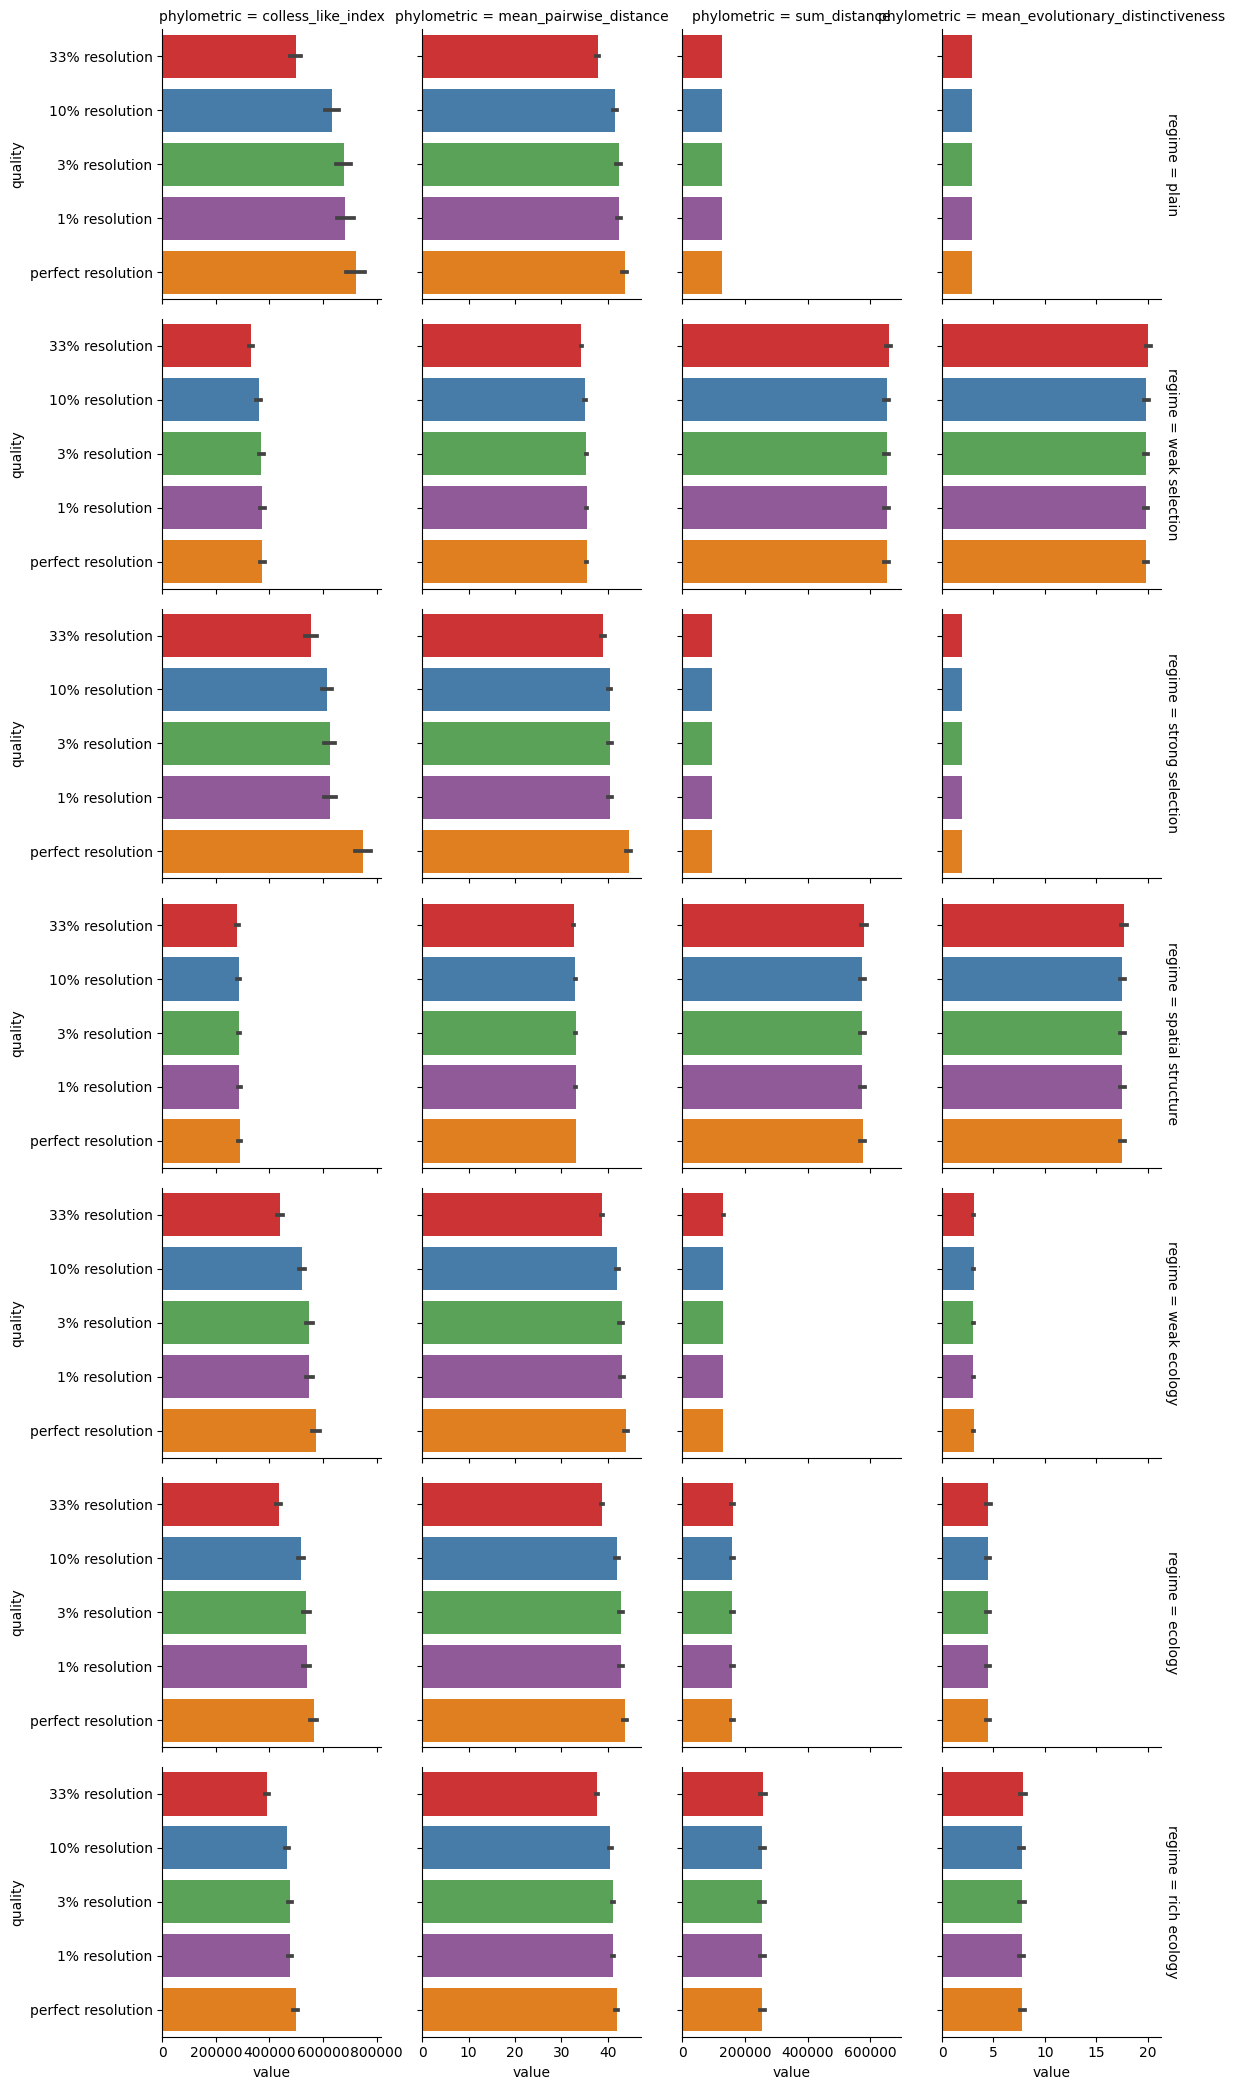

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.png


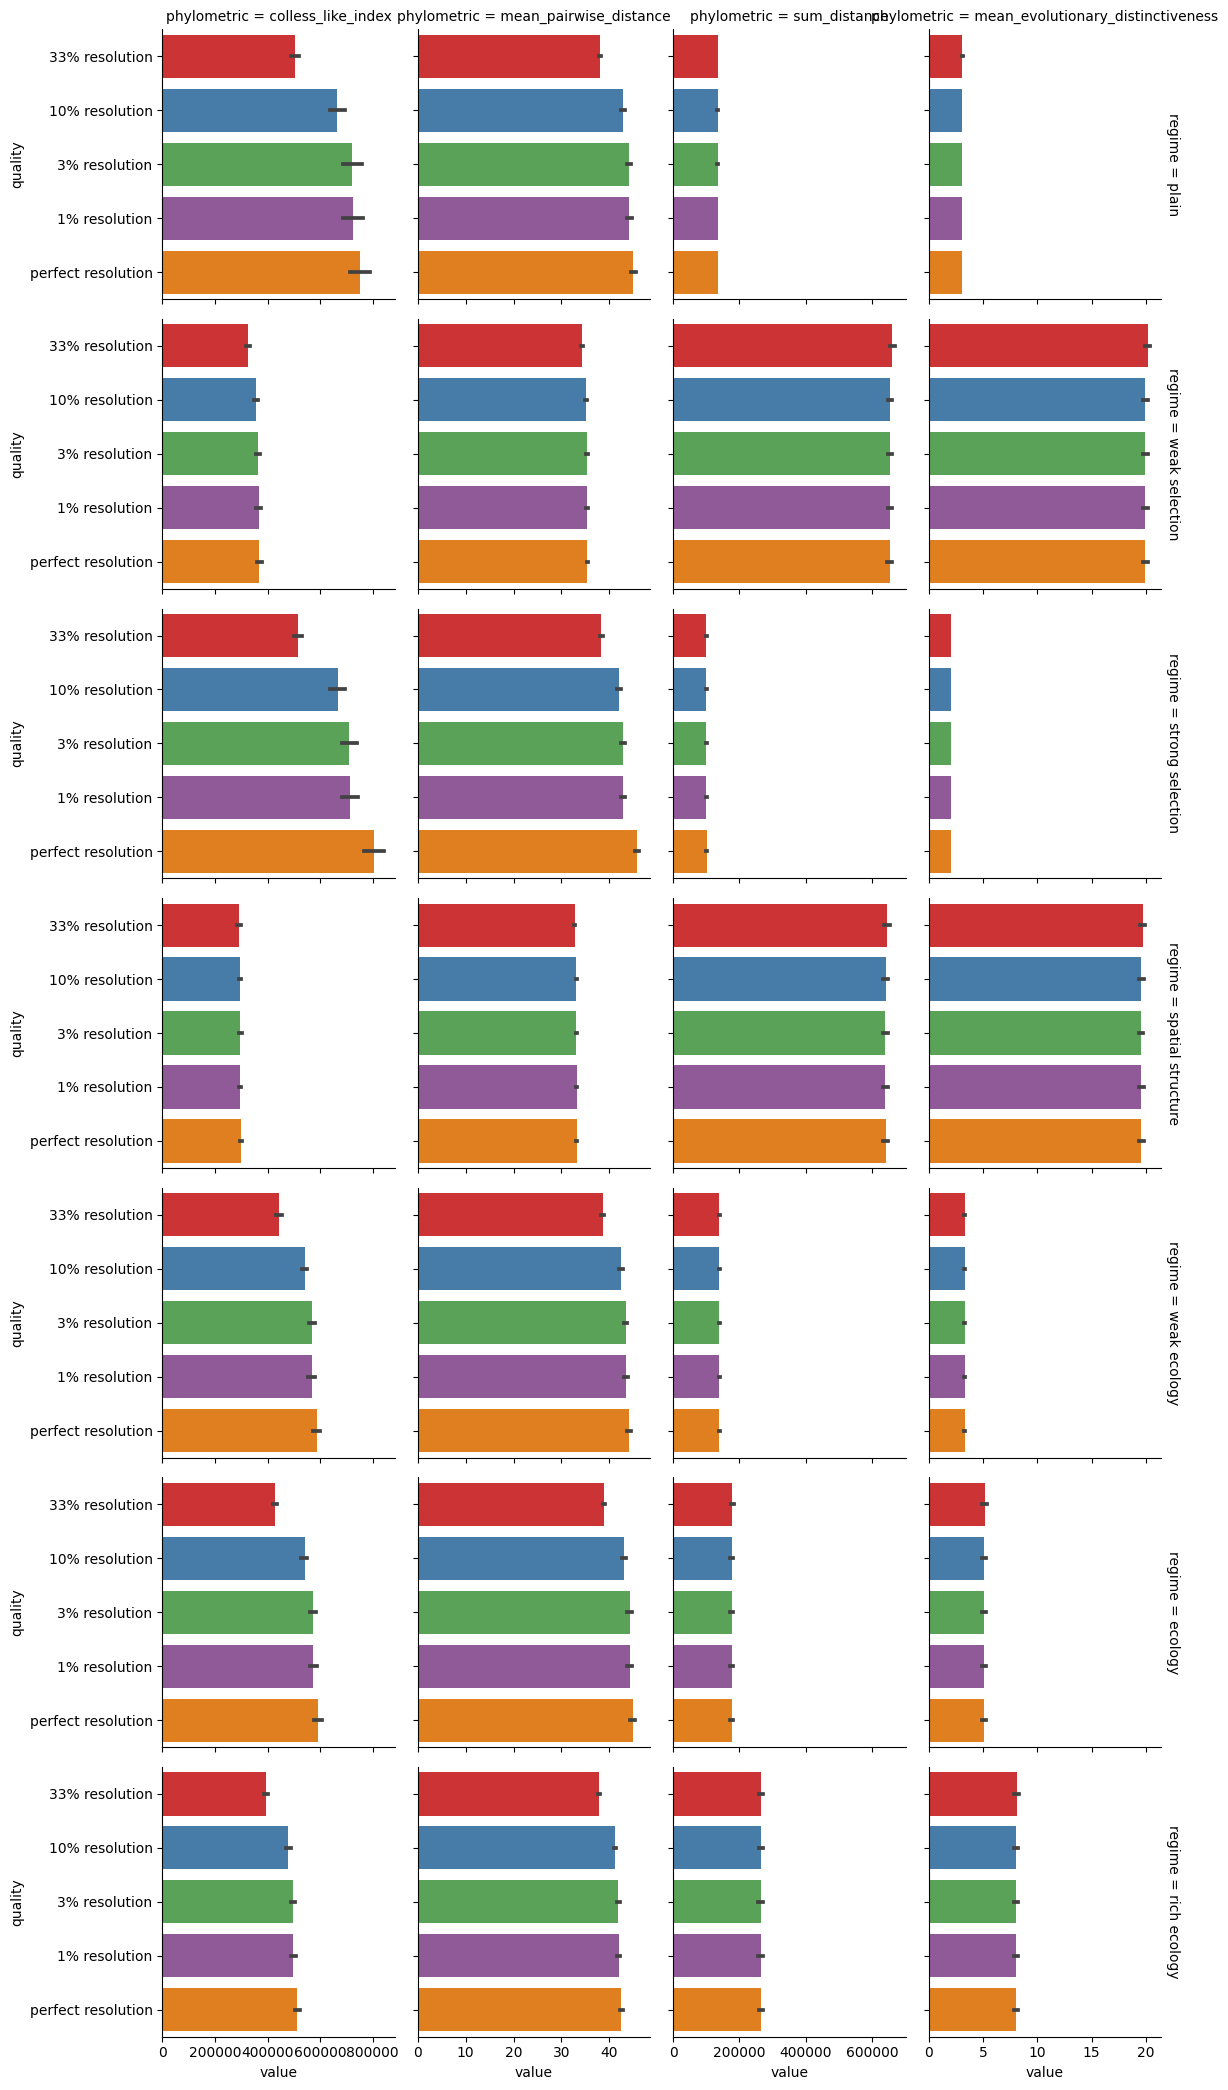

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.png


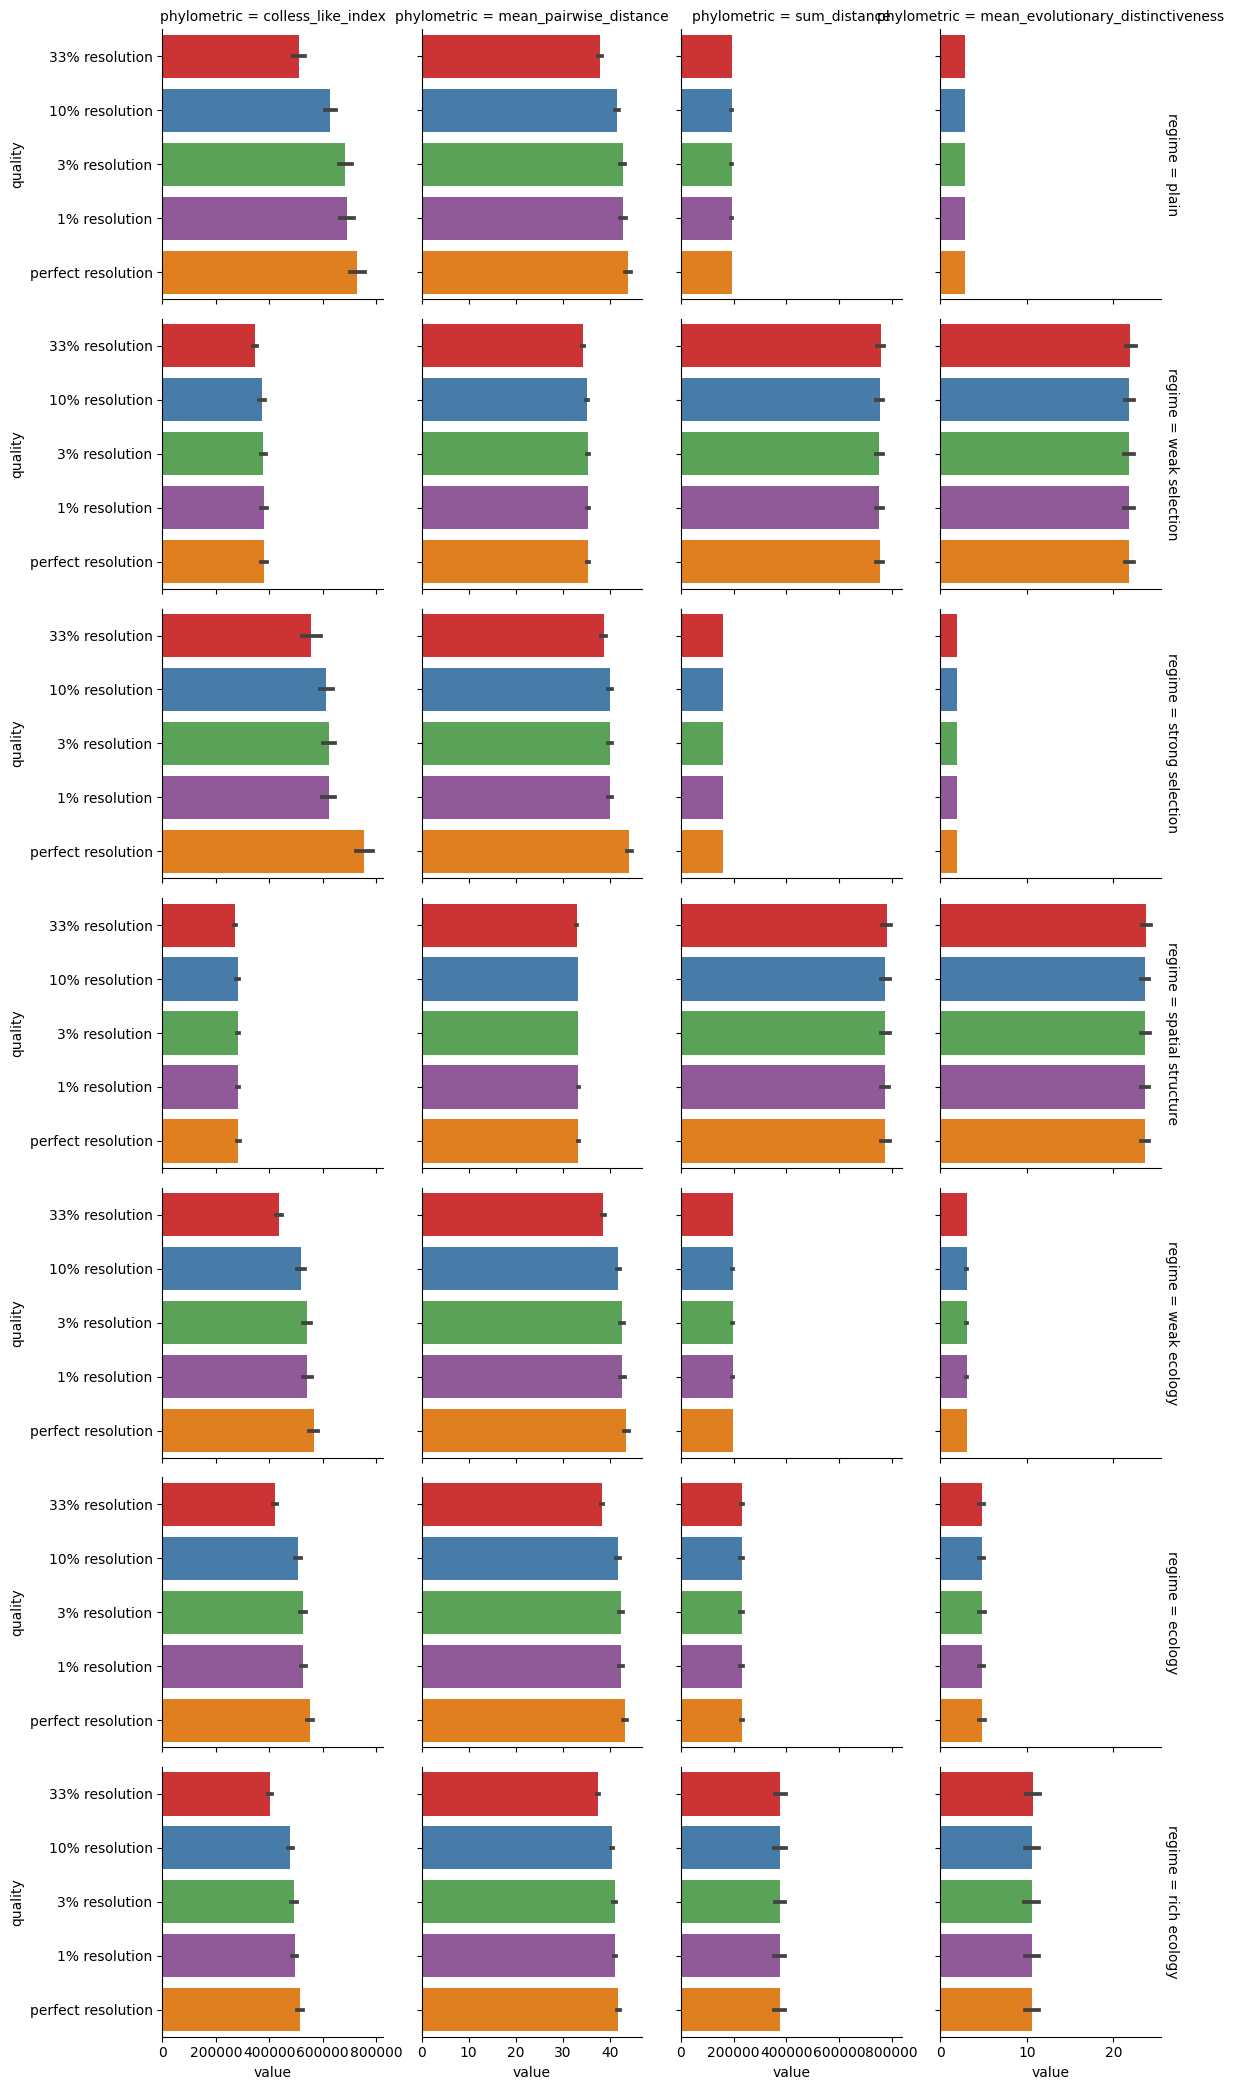

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.png


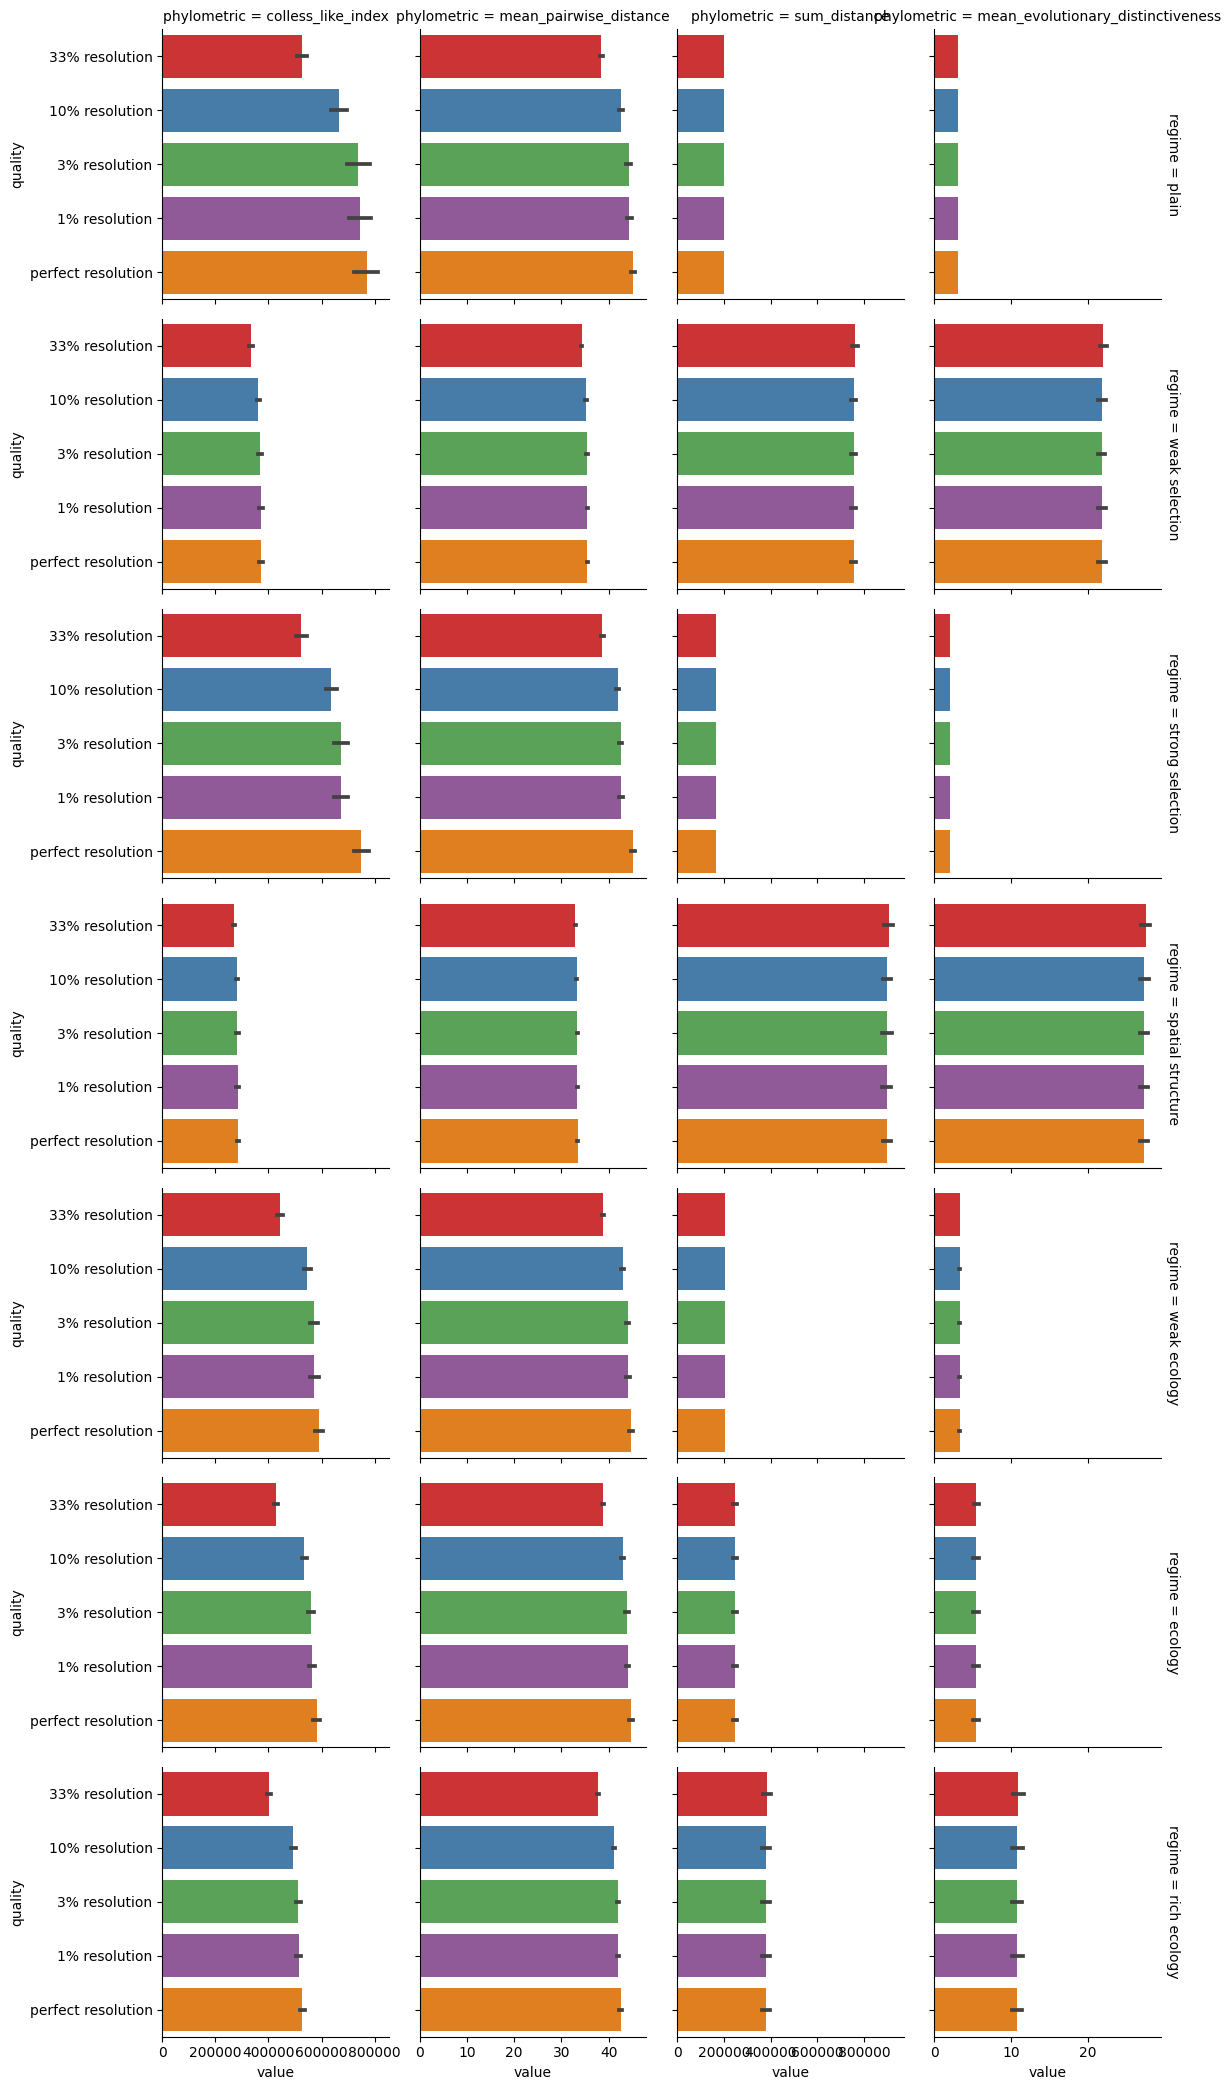

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.png


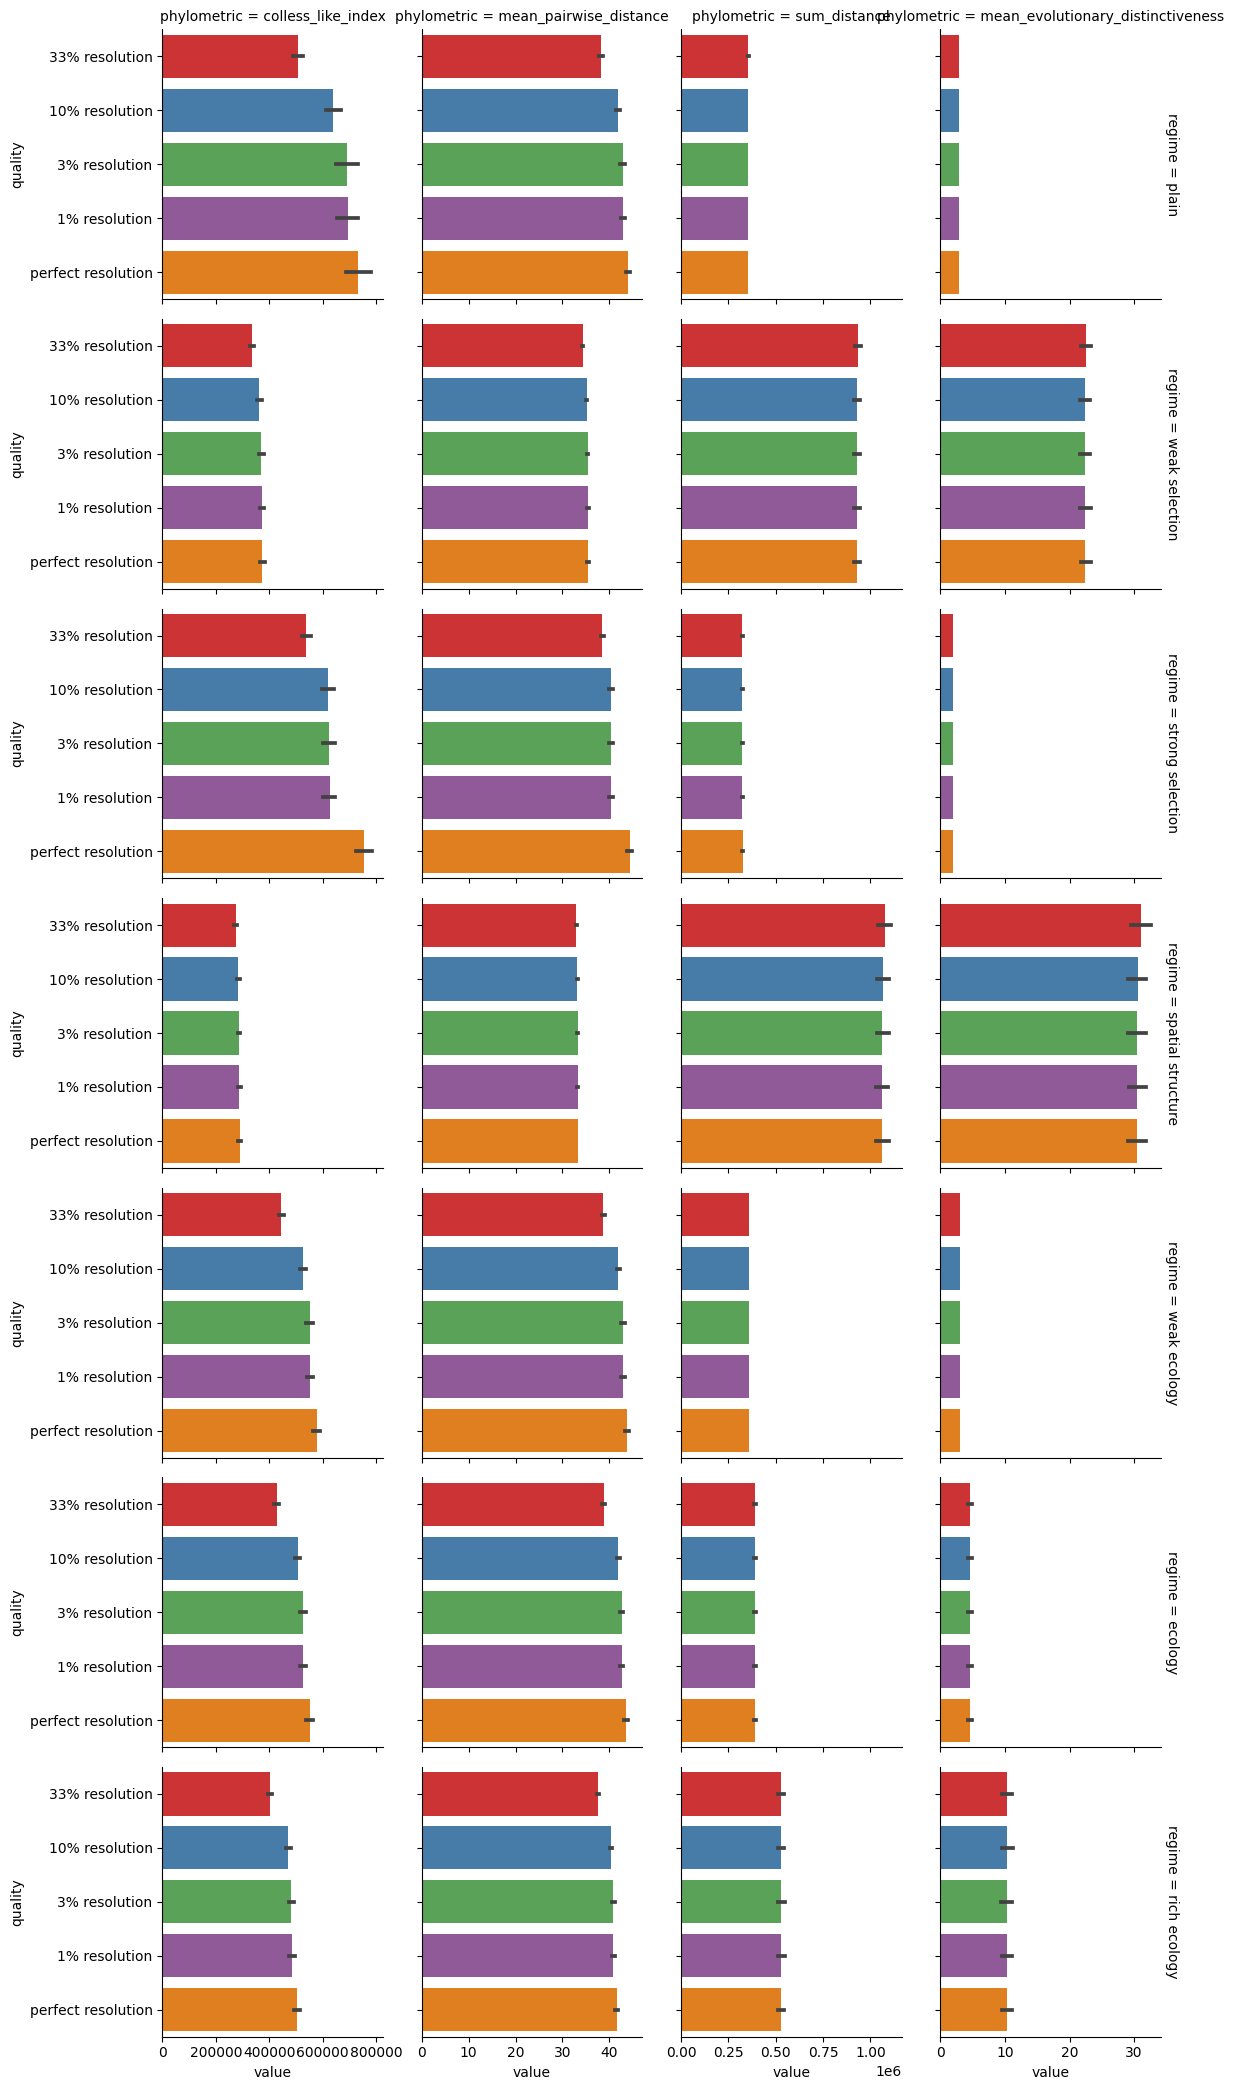

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.png


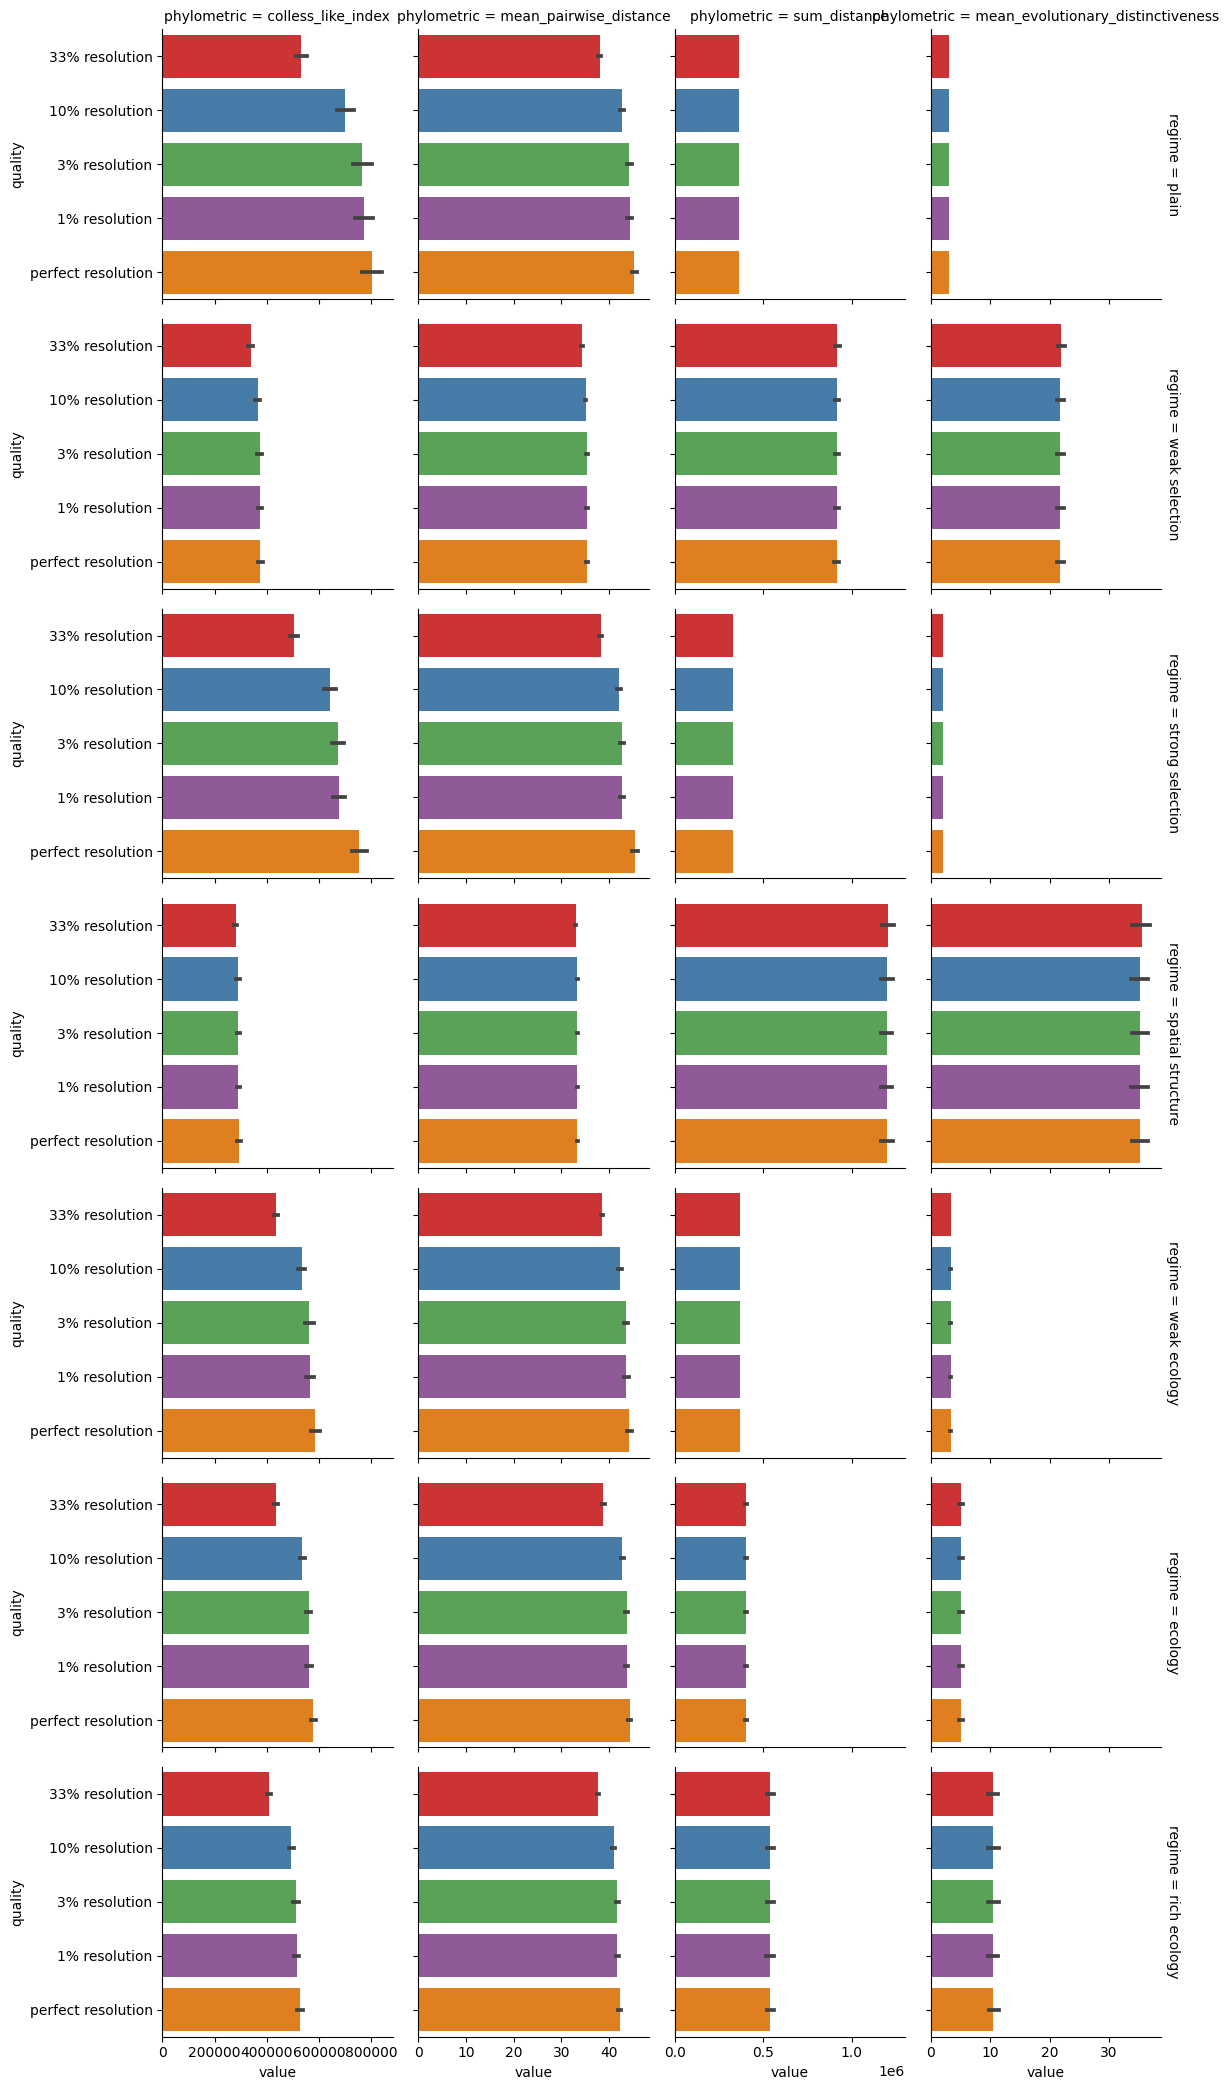

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+row=regime+viz=boxplot+x=value+y=quality+ext=.png


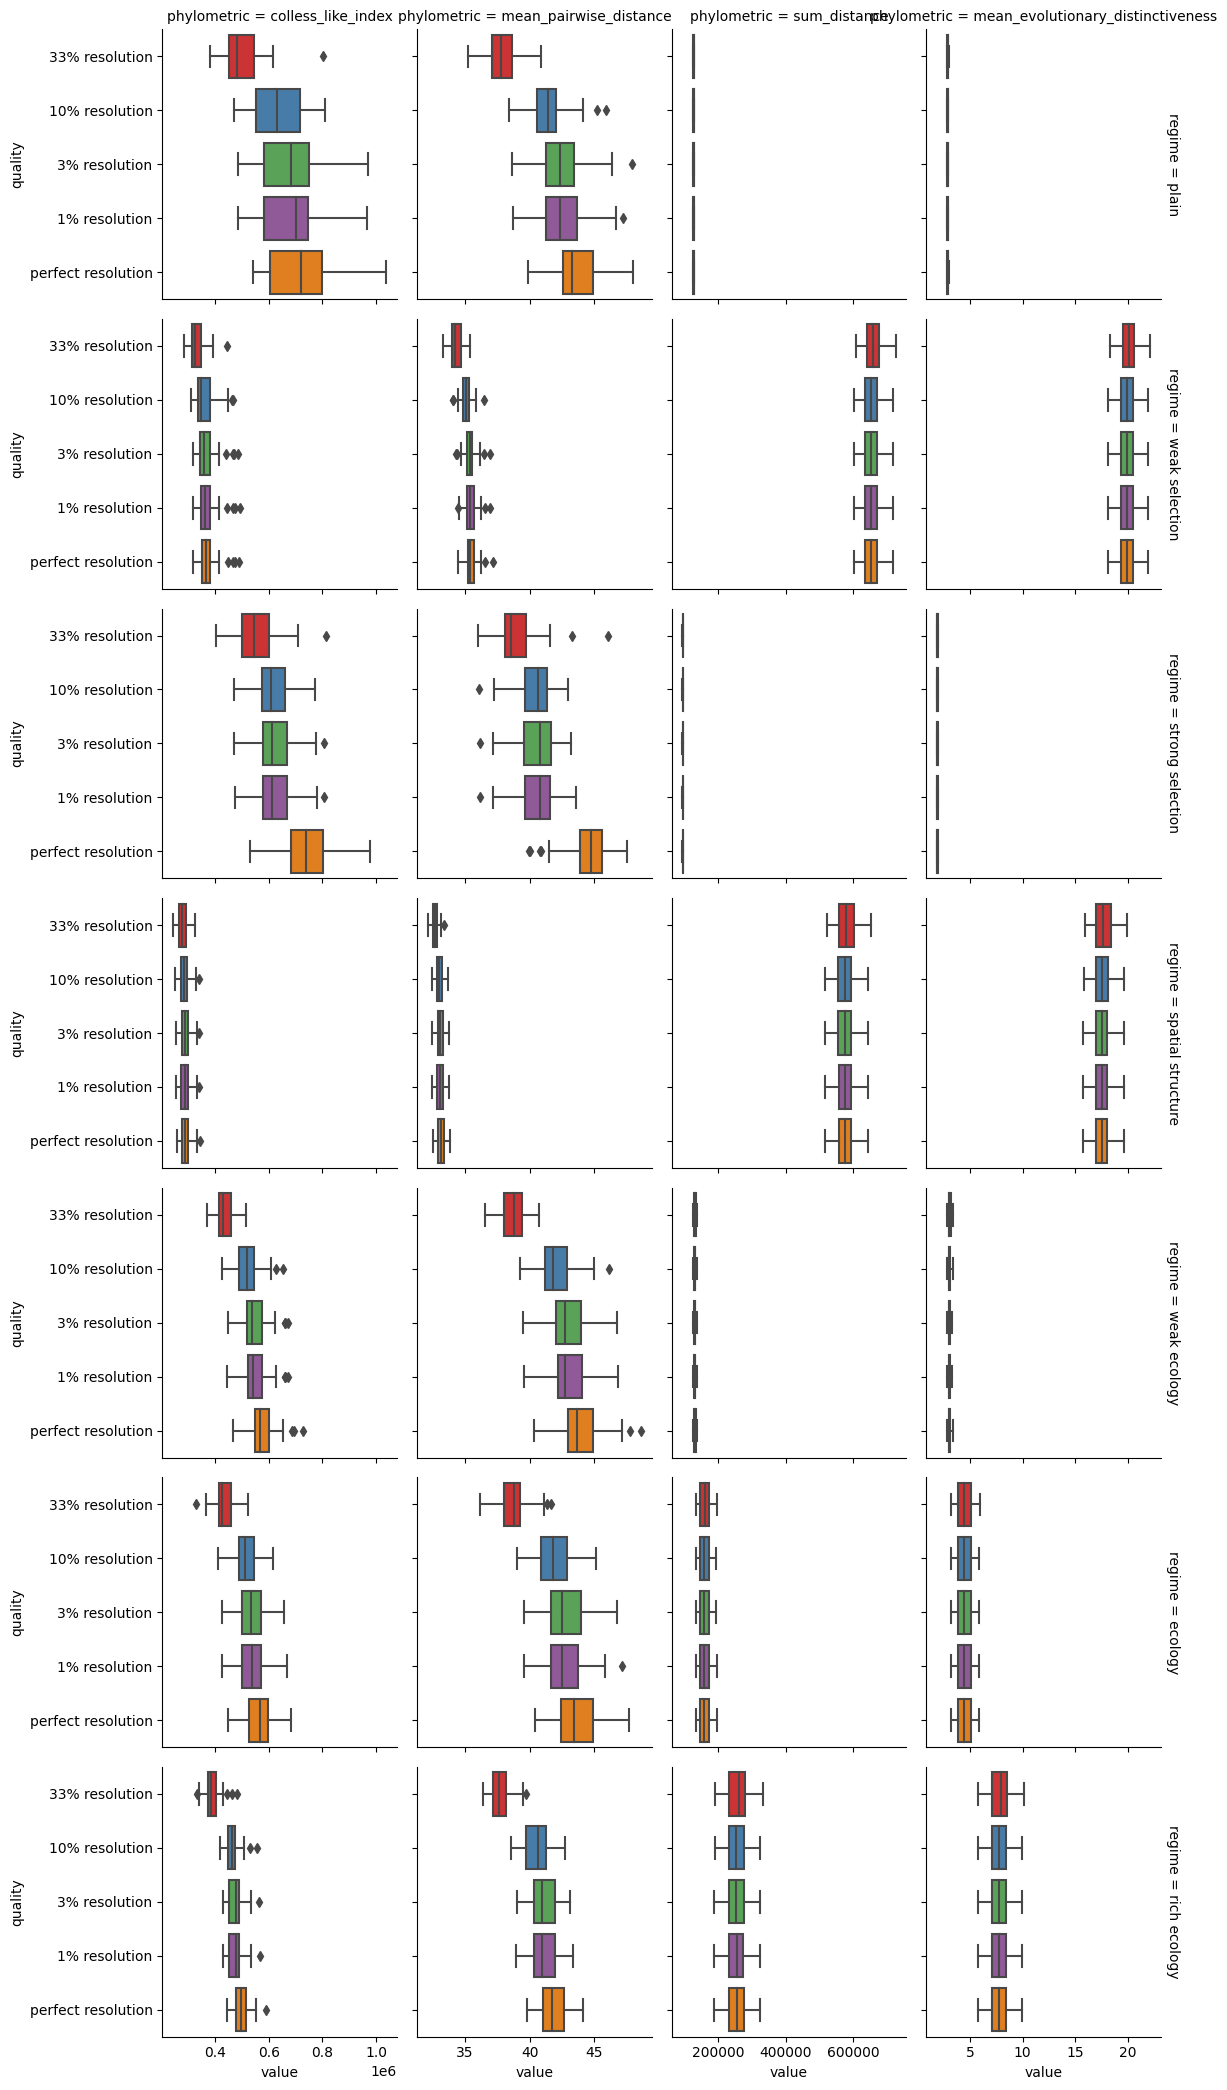

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+row=regime+viz=boxplot+x=value+y=quality+ext=.png


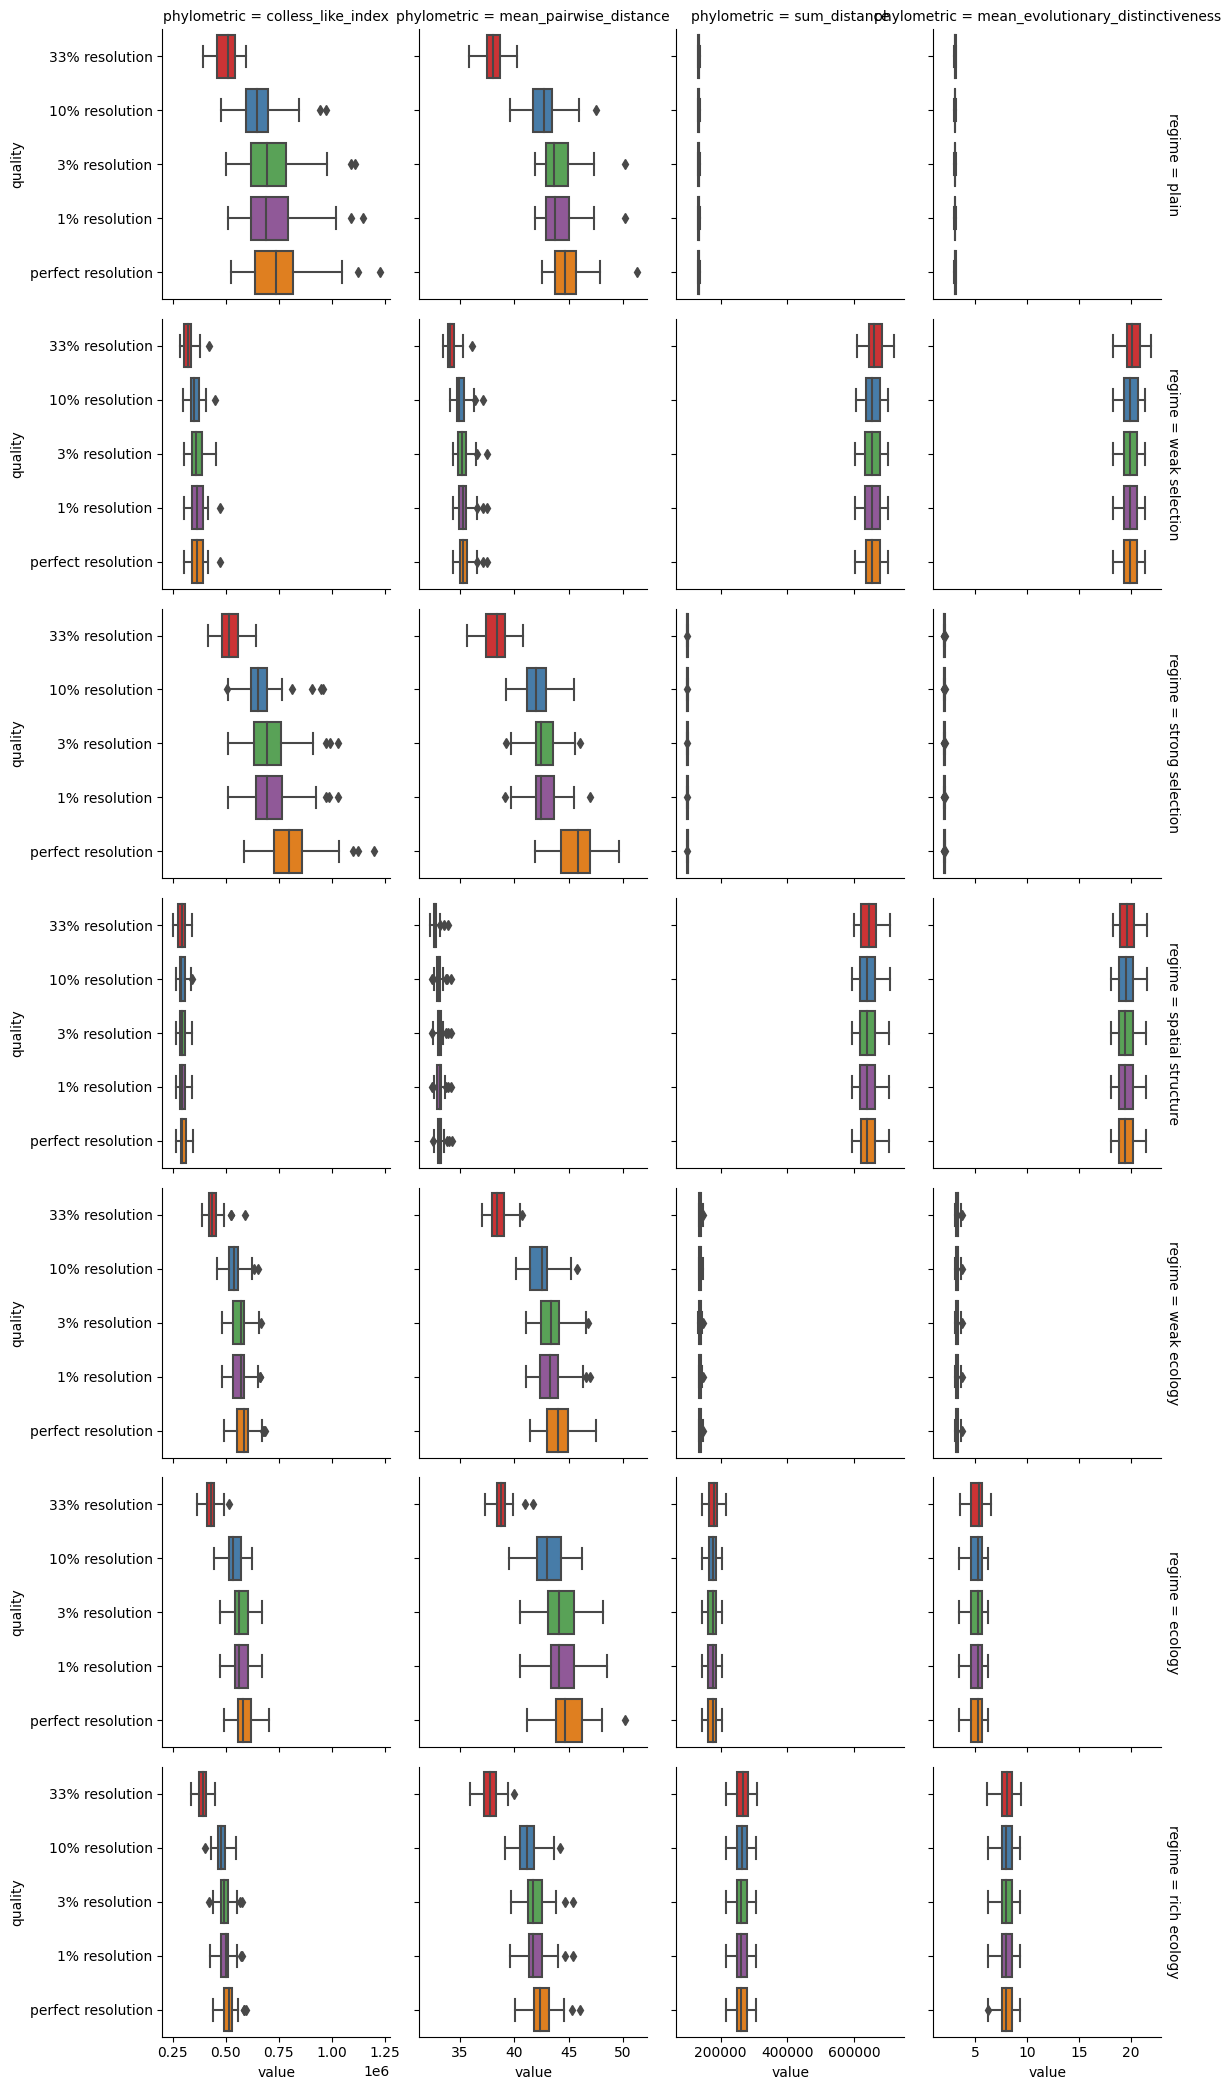

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+row=regime+viz=boxplot+x=value+y=quality+ext=.png


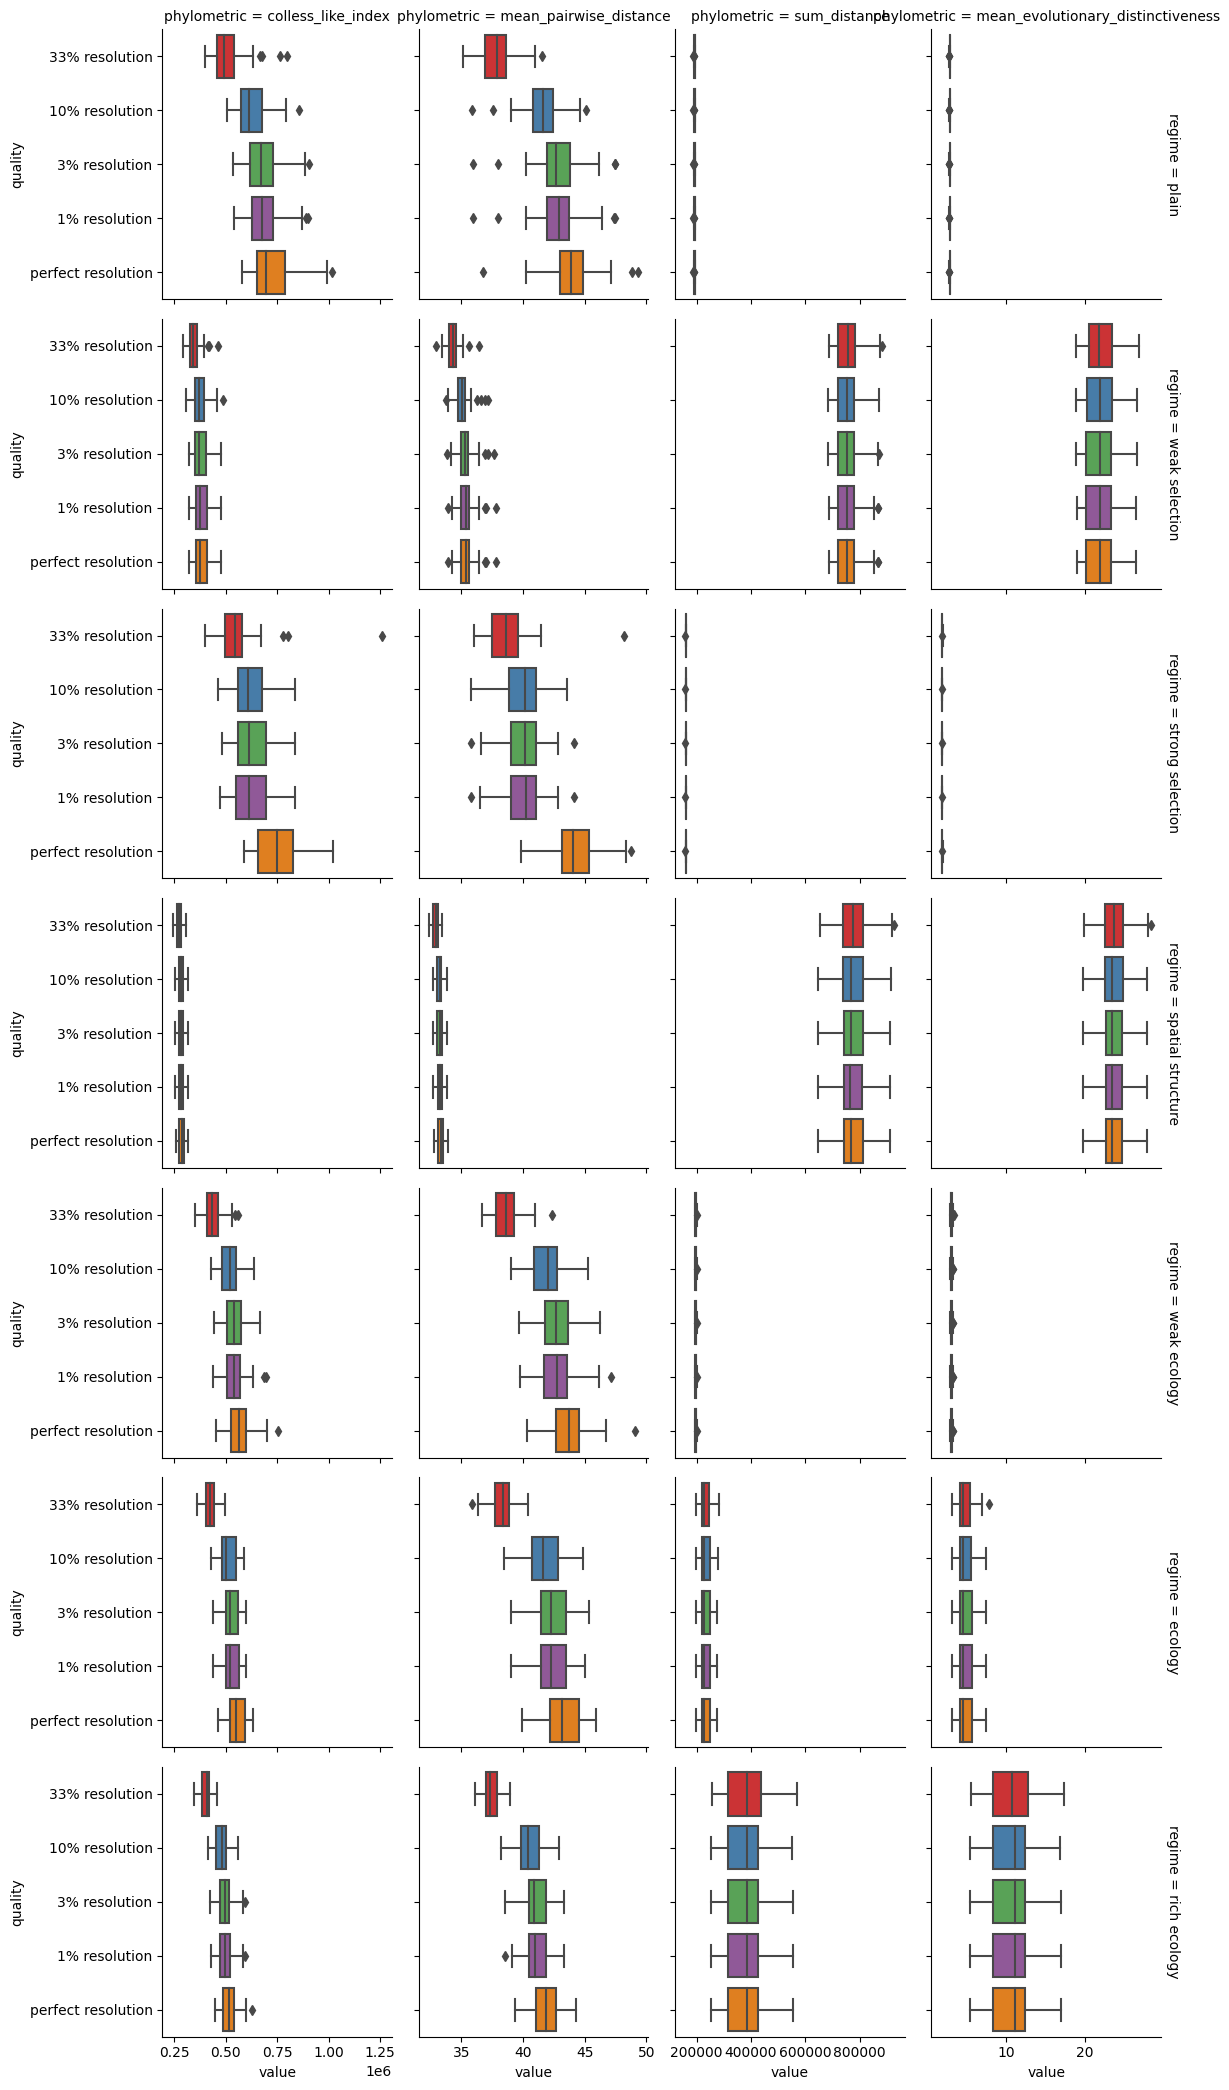

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+row=regime+viz=boxplot+x=value+y=quality+ext=.png


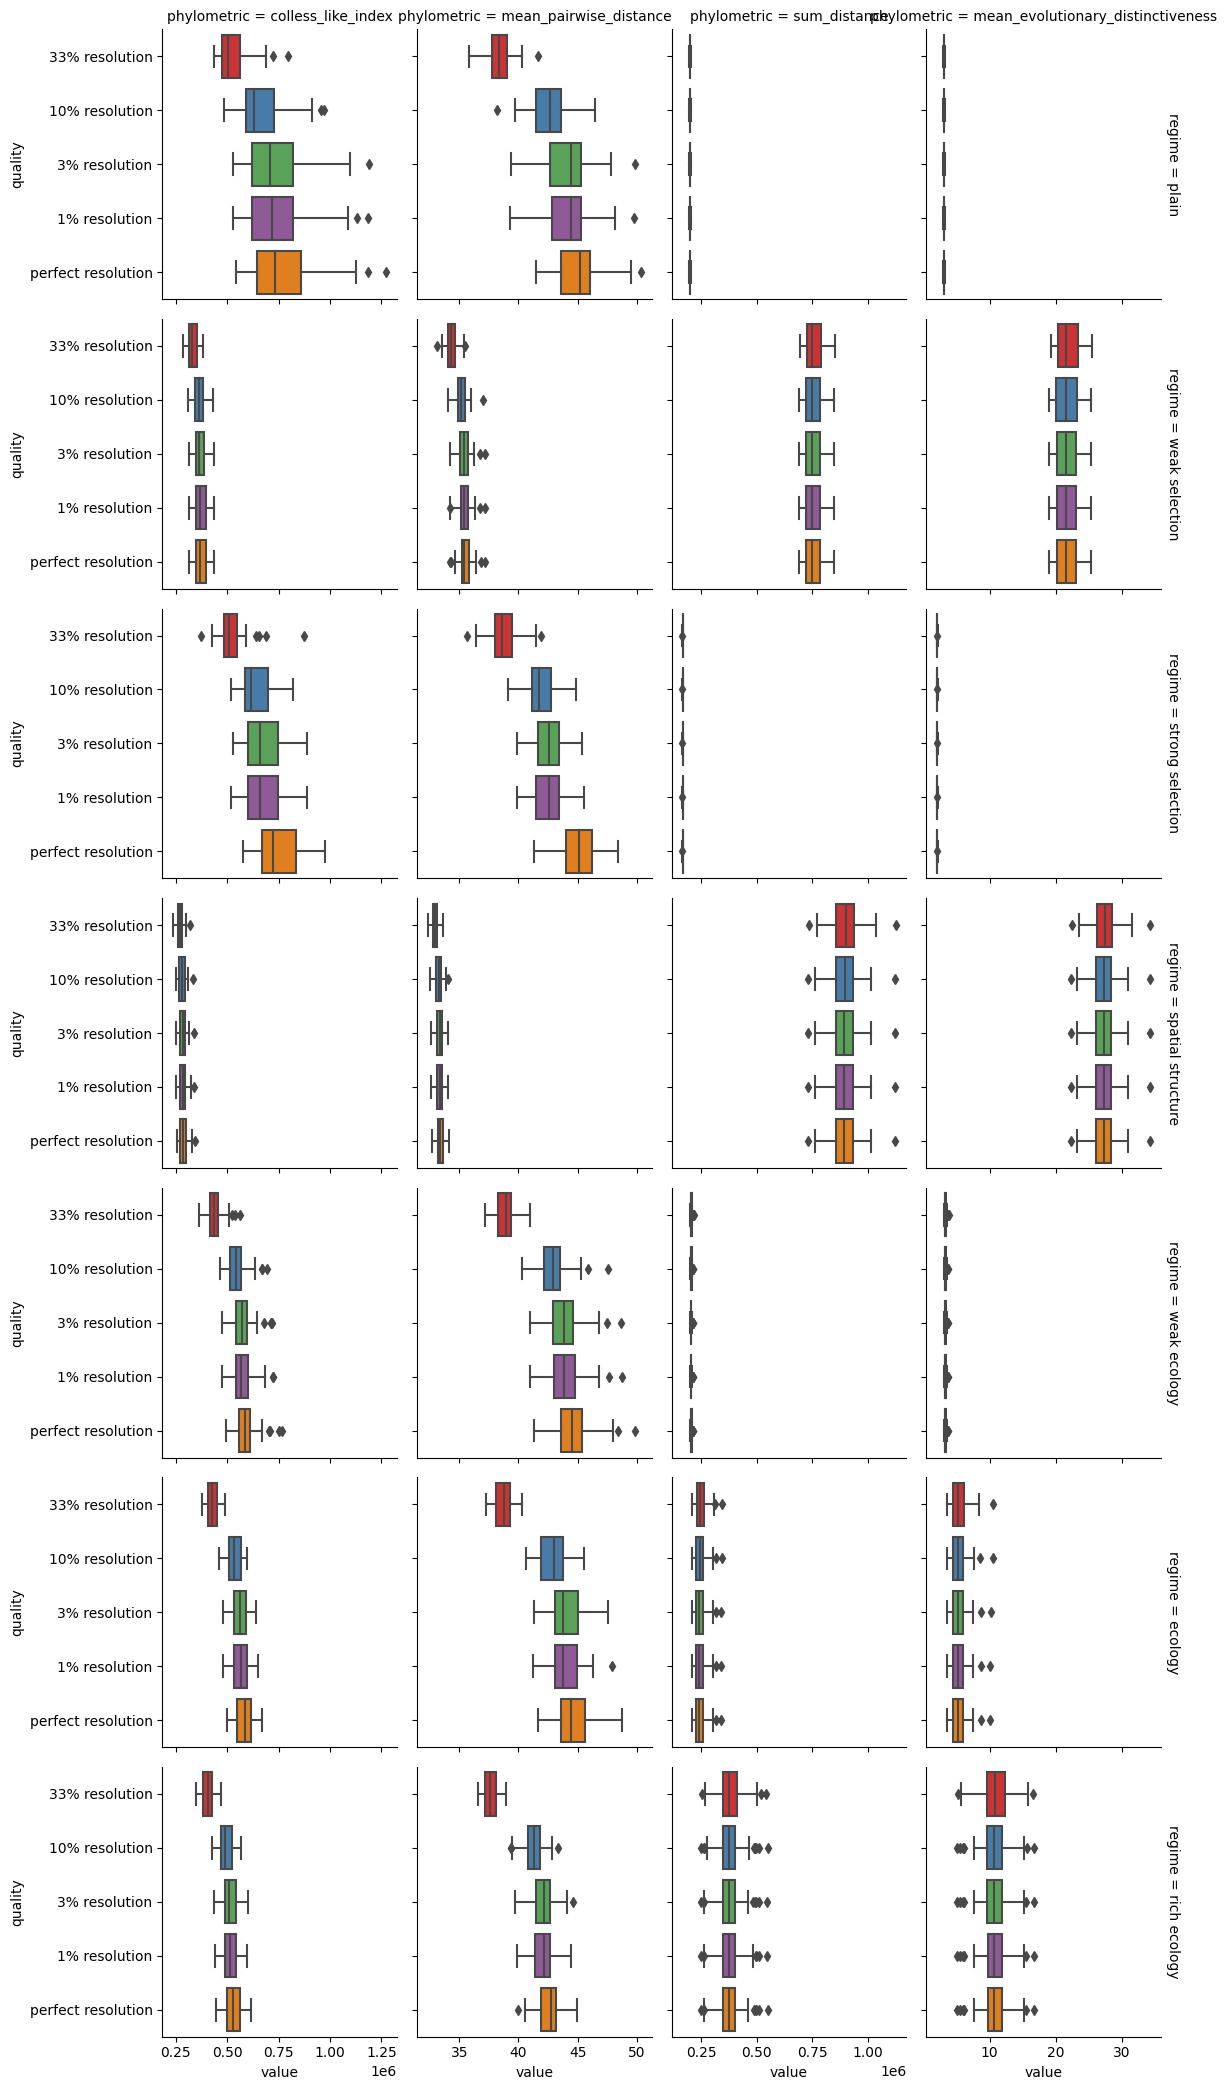

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+row=regime+viz=boxplot+x=value+y=quality+ext=.png


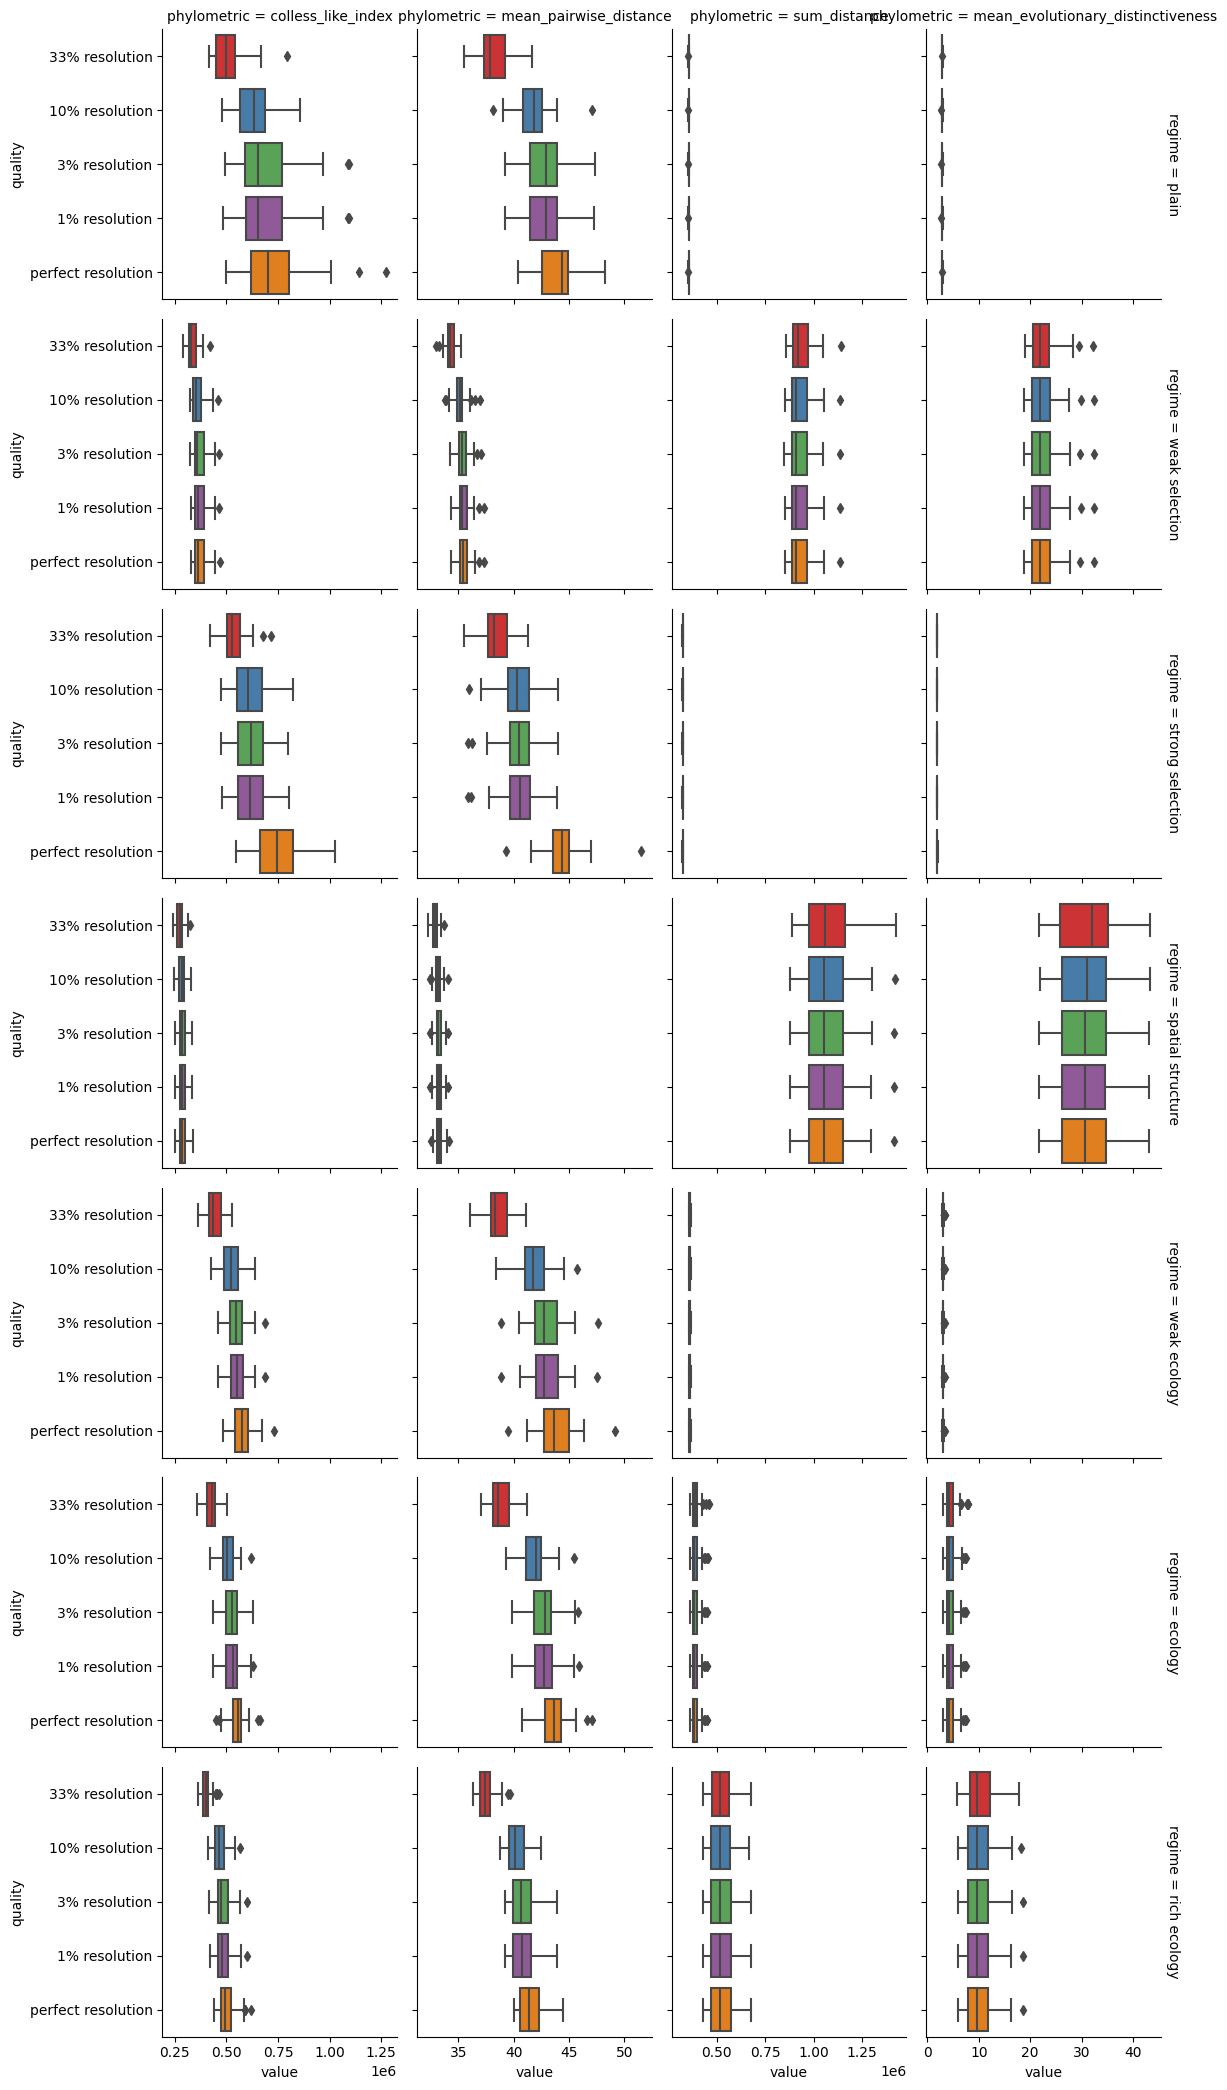

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+row=regime+viz=boxplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+row=regime+viz=boxplot+x=value+y=quality+ext=.png


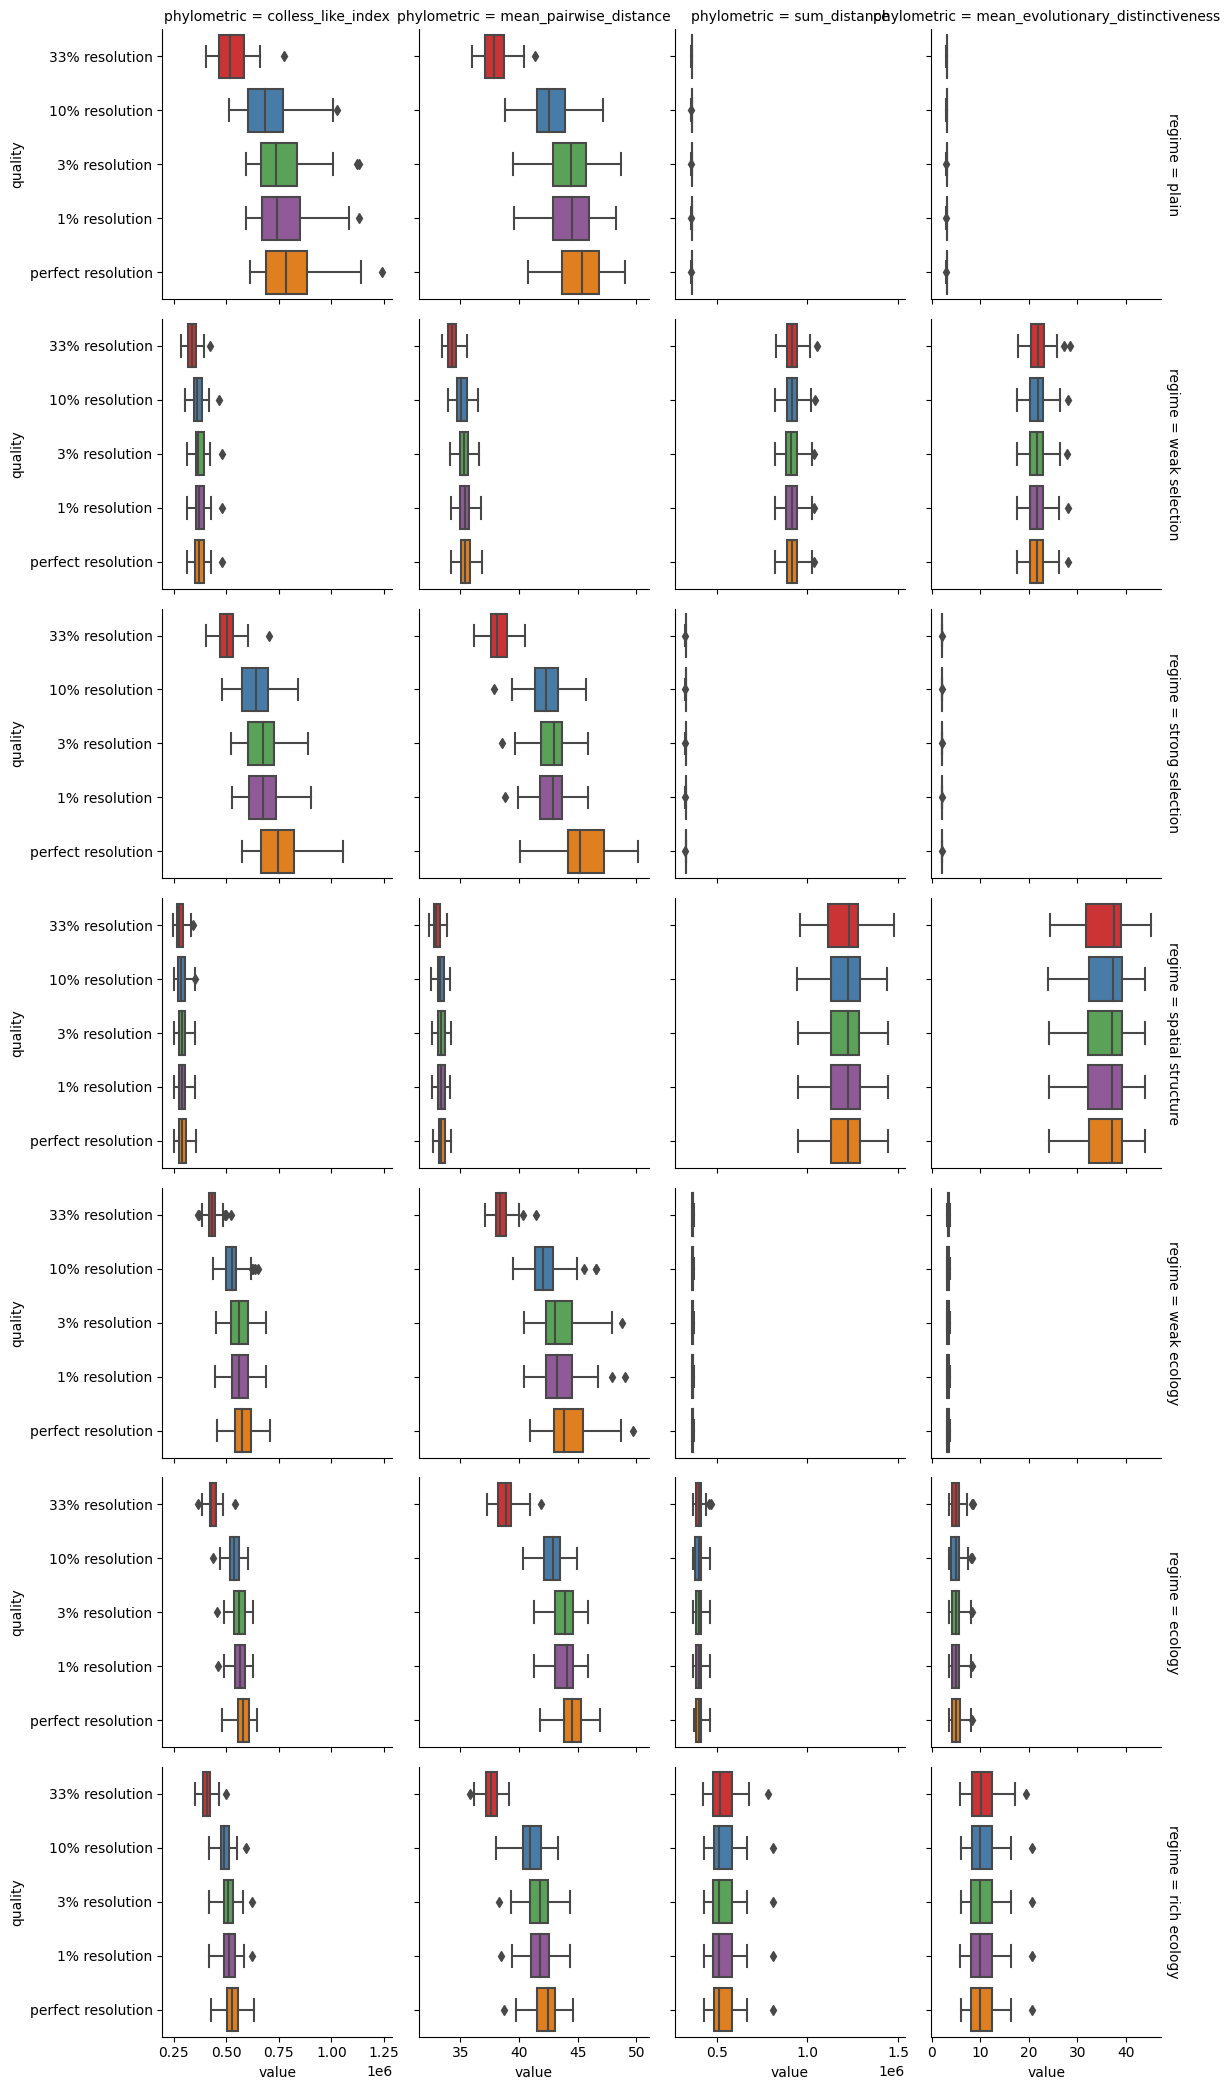

teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+row=regime+viz=violinplot+x=value+y=quality+ext=.png


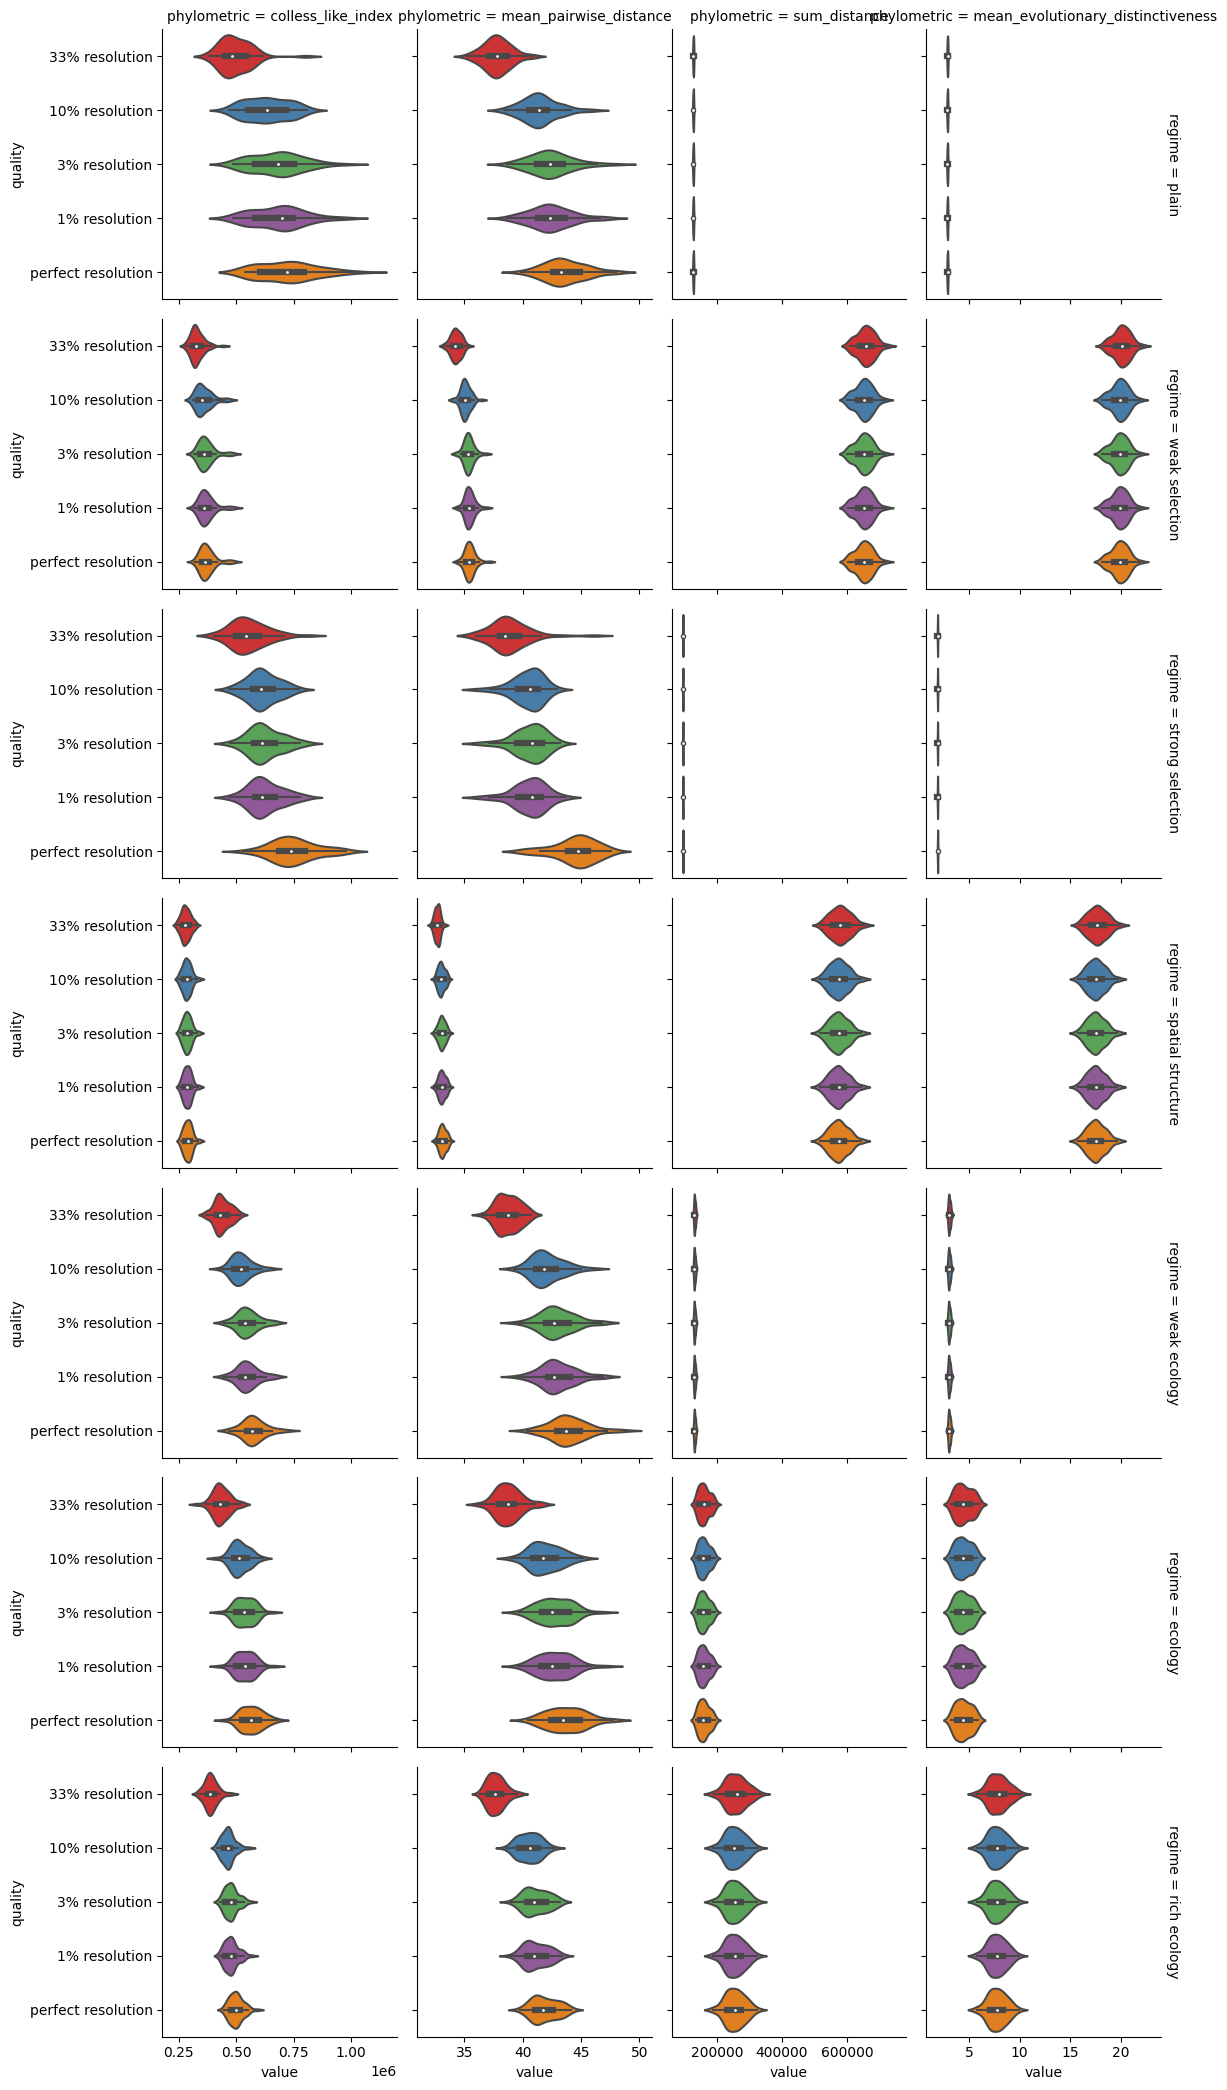

teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+row=regime+viz=violinplot+x=value+y=quality+ext=.png


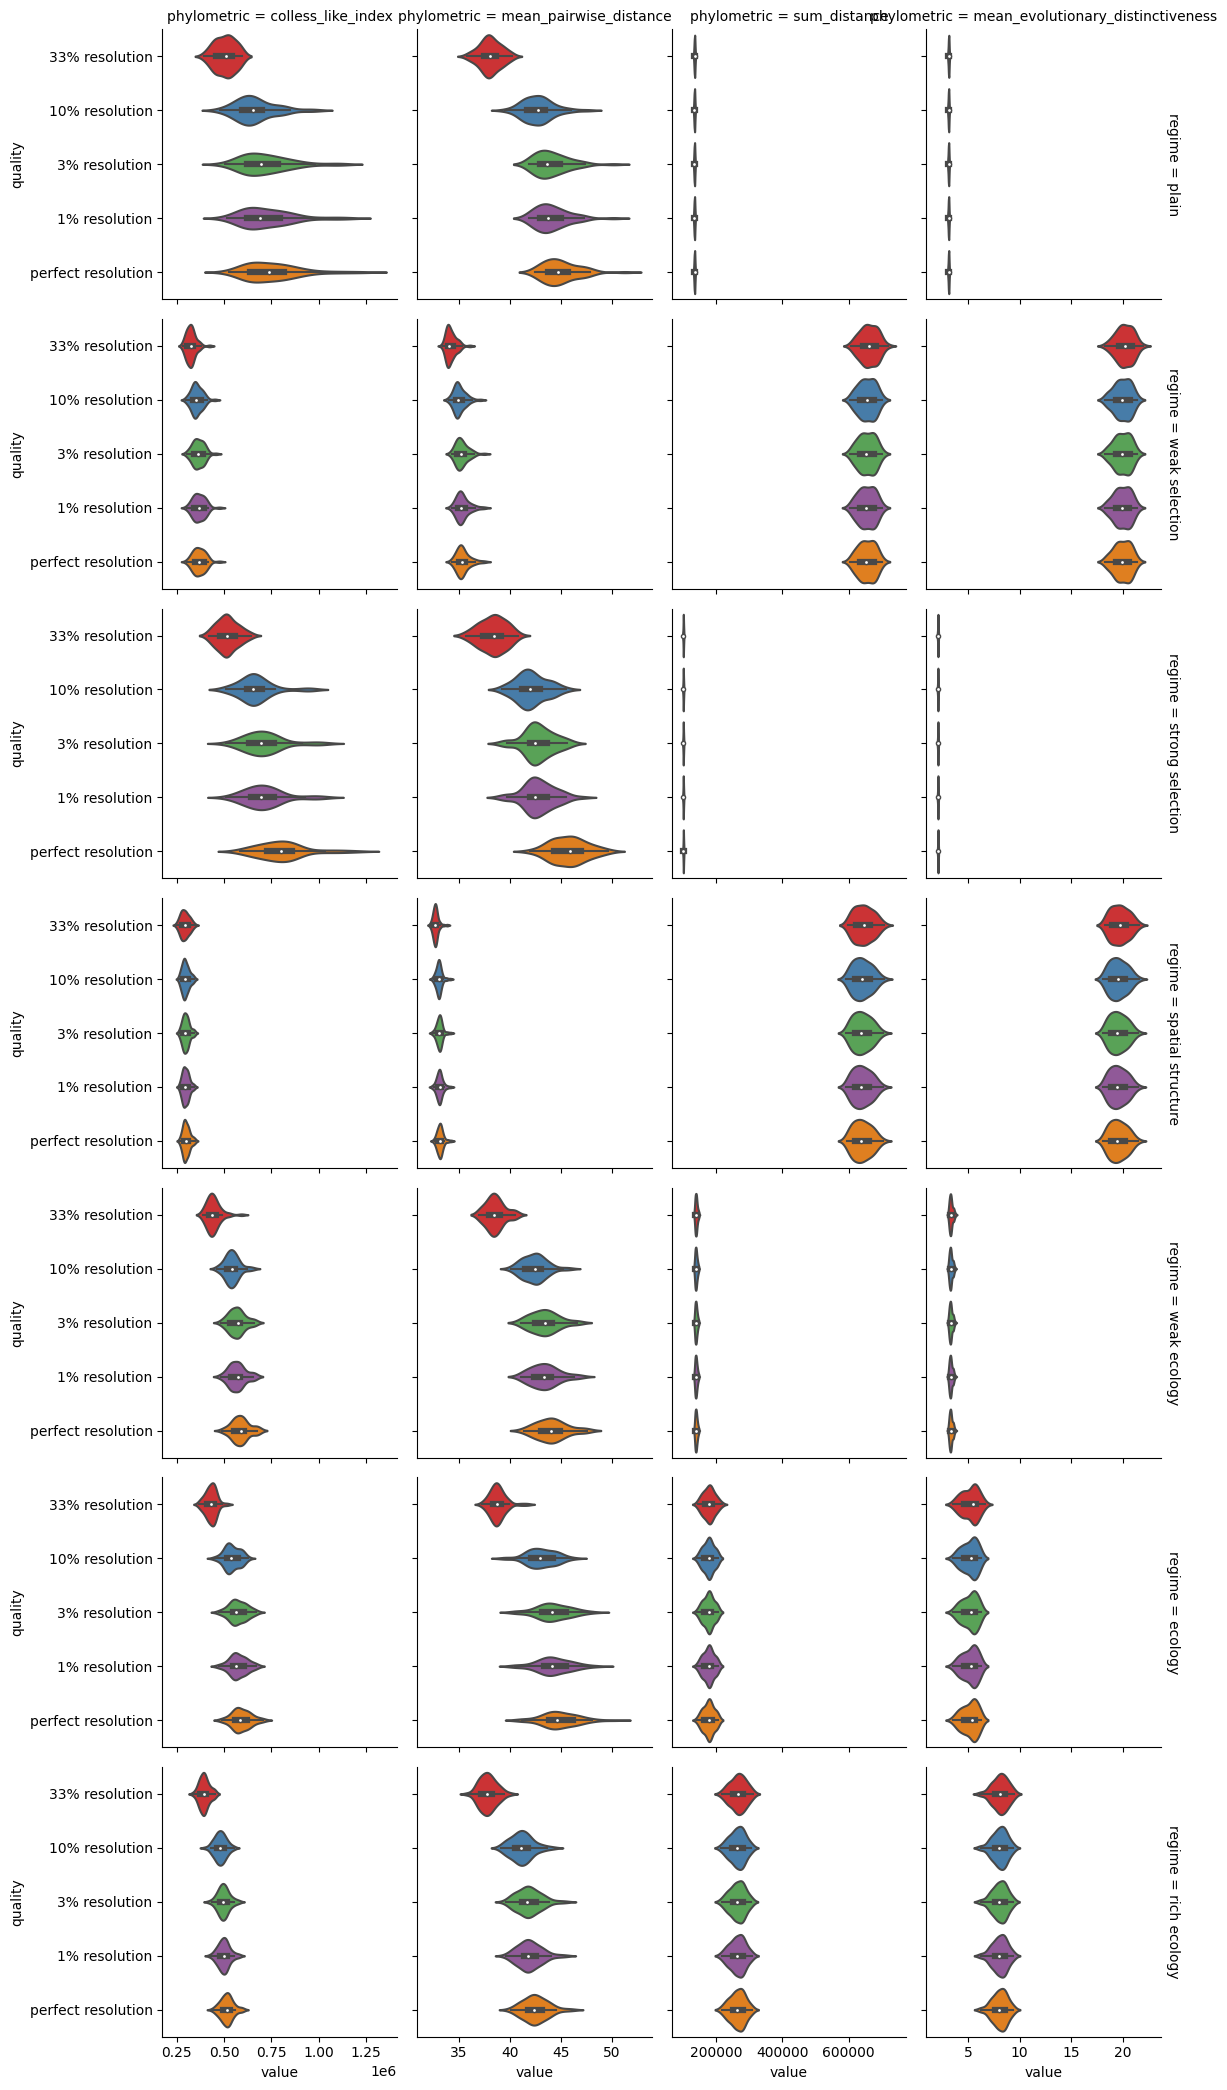

teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+row=regime+viz=violinplot+x=value+y=quality+ext=.png


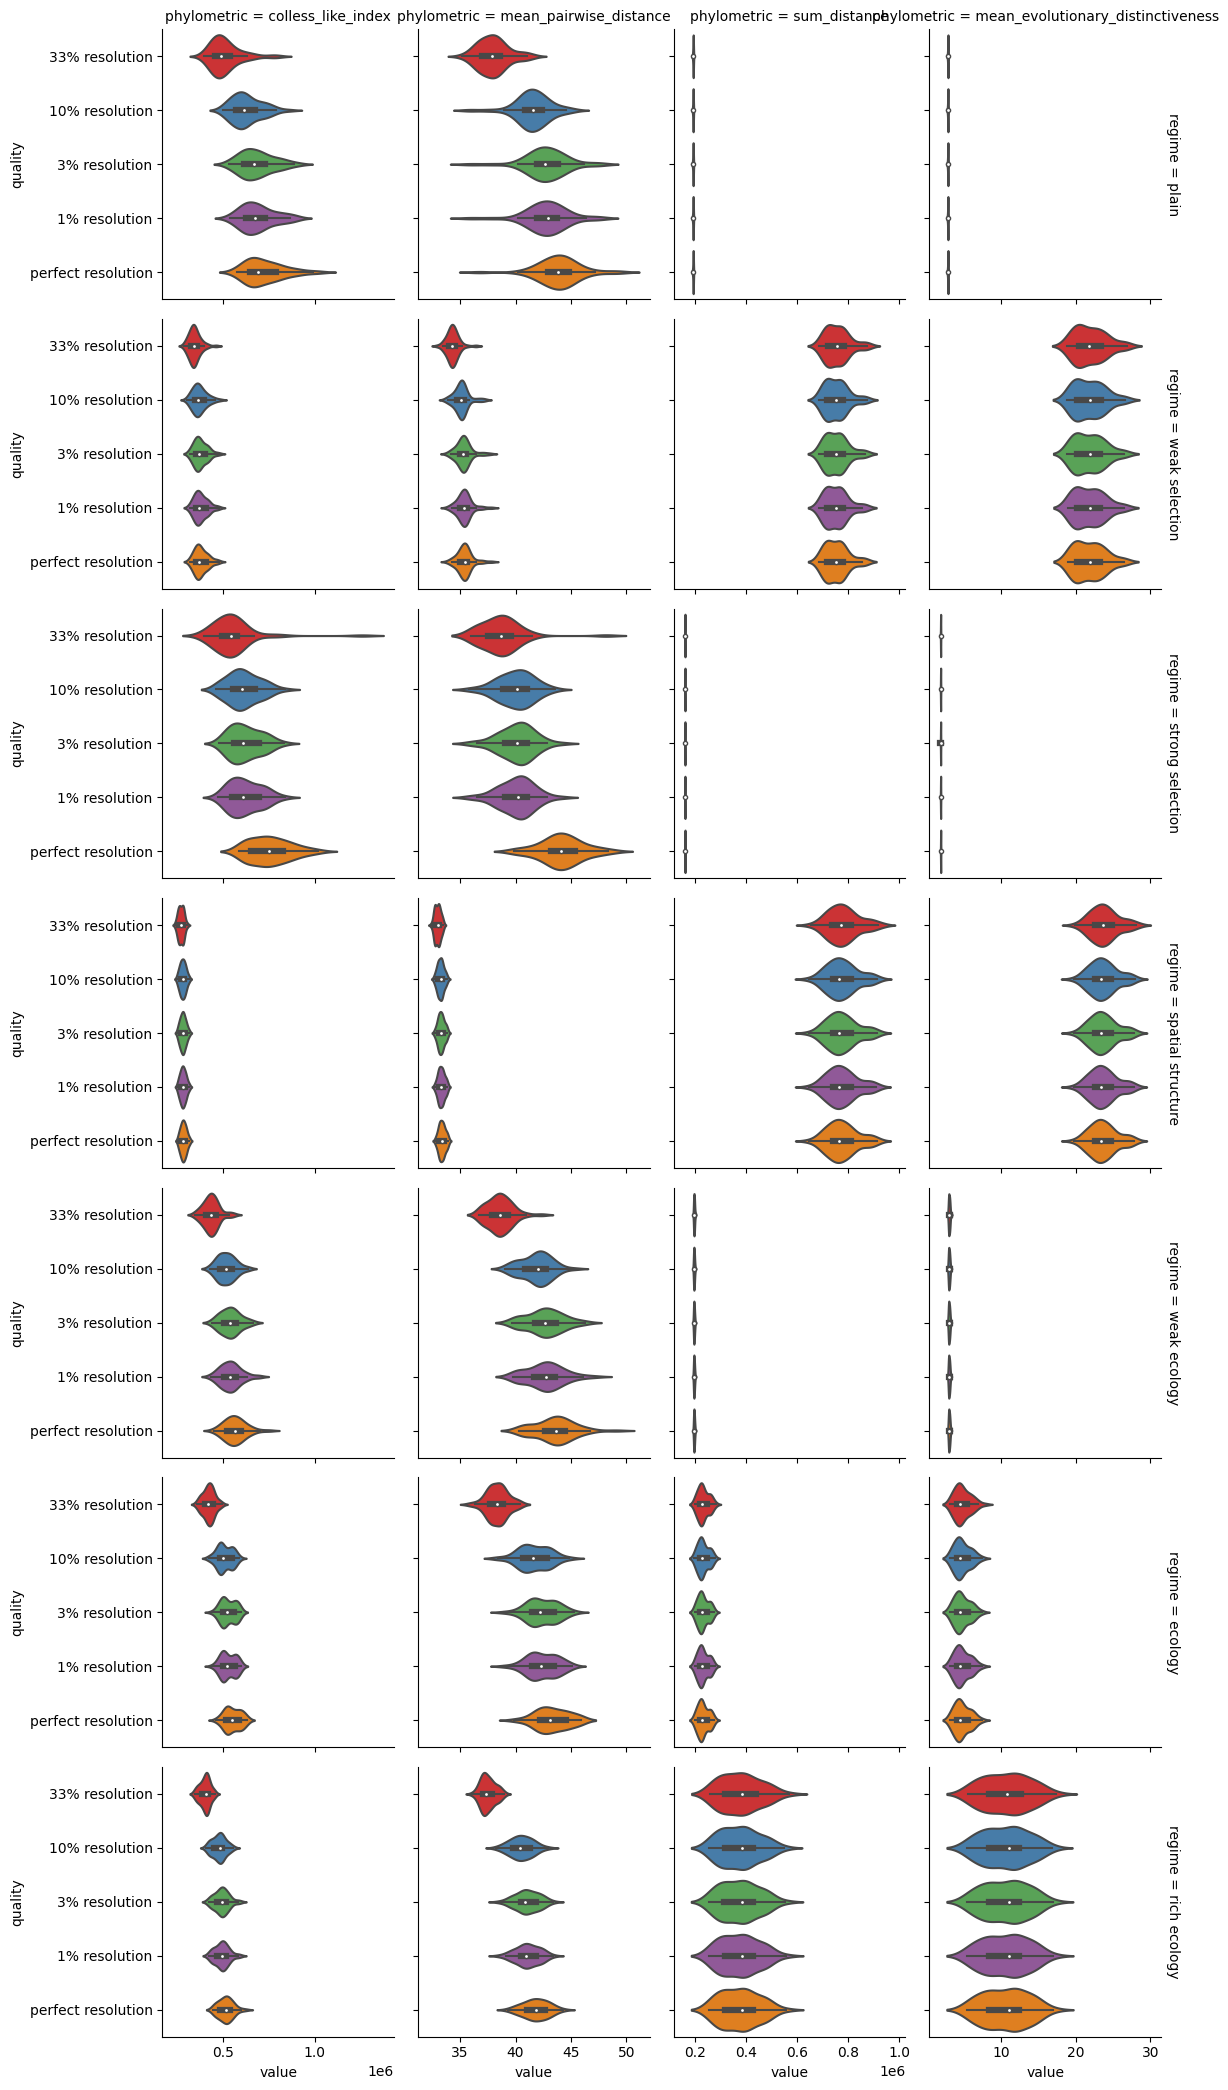

teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+row=regime+viz=violinplot+x=value+y=quality+ext=.png


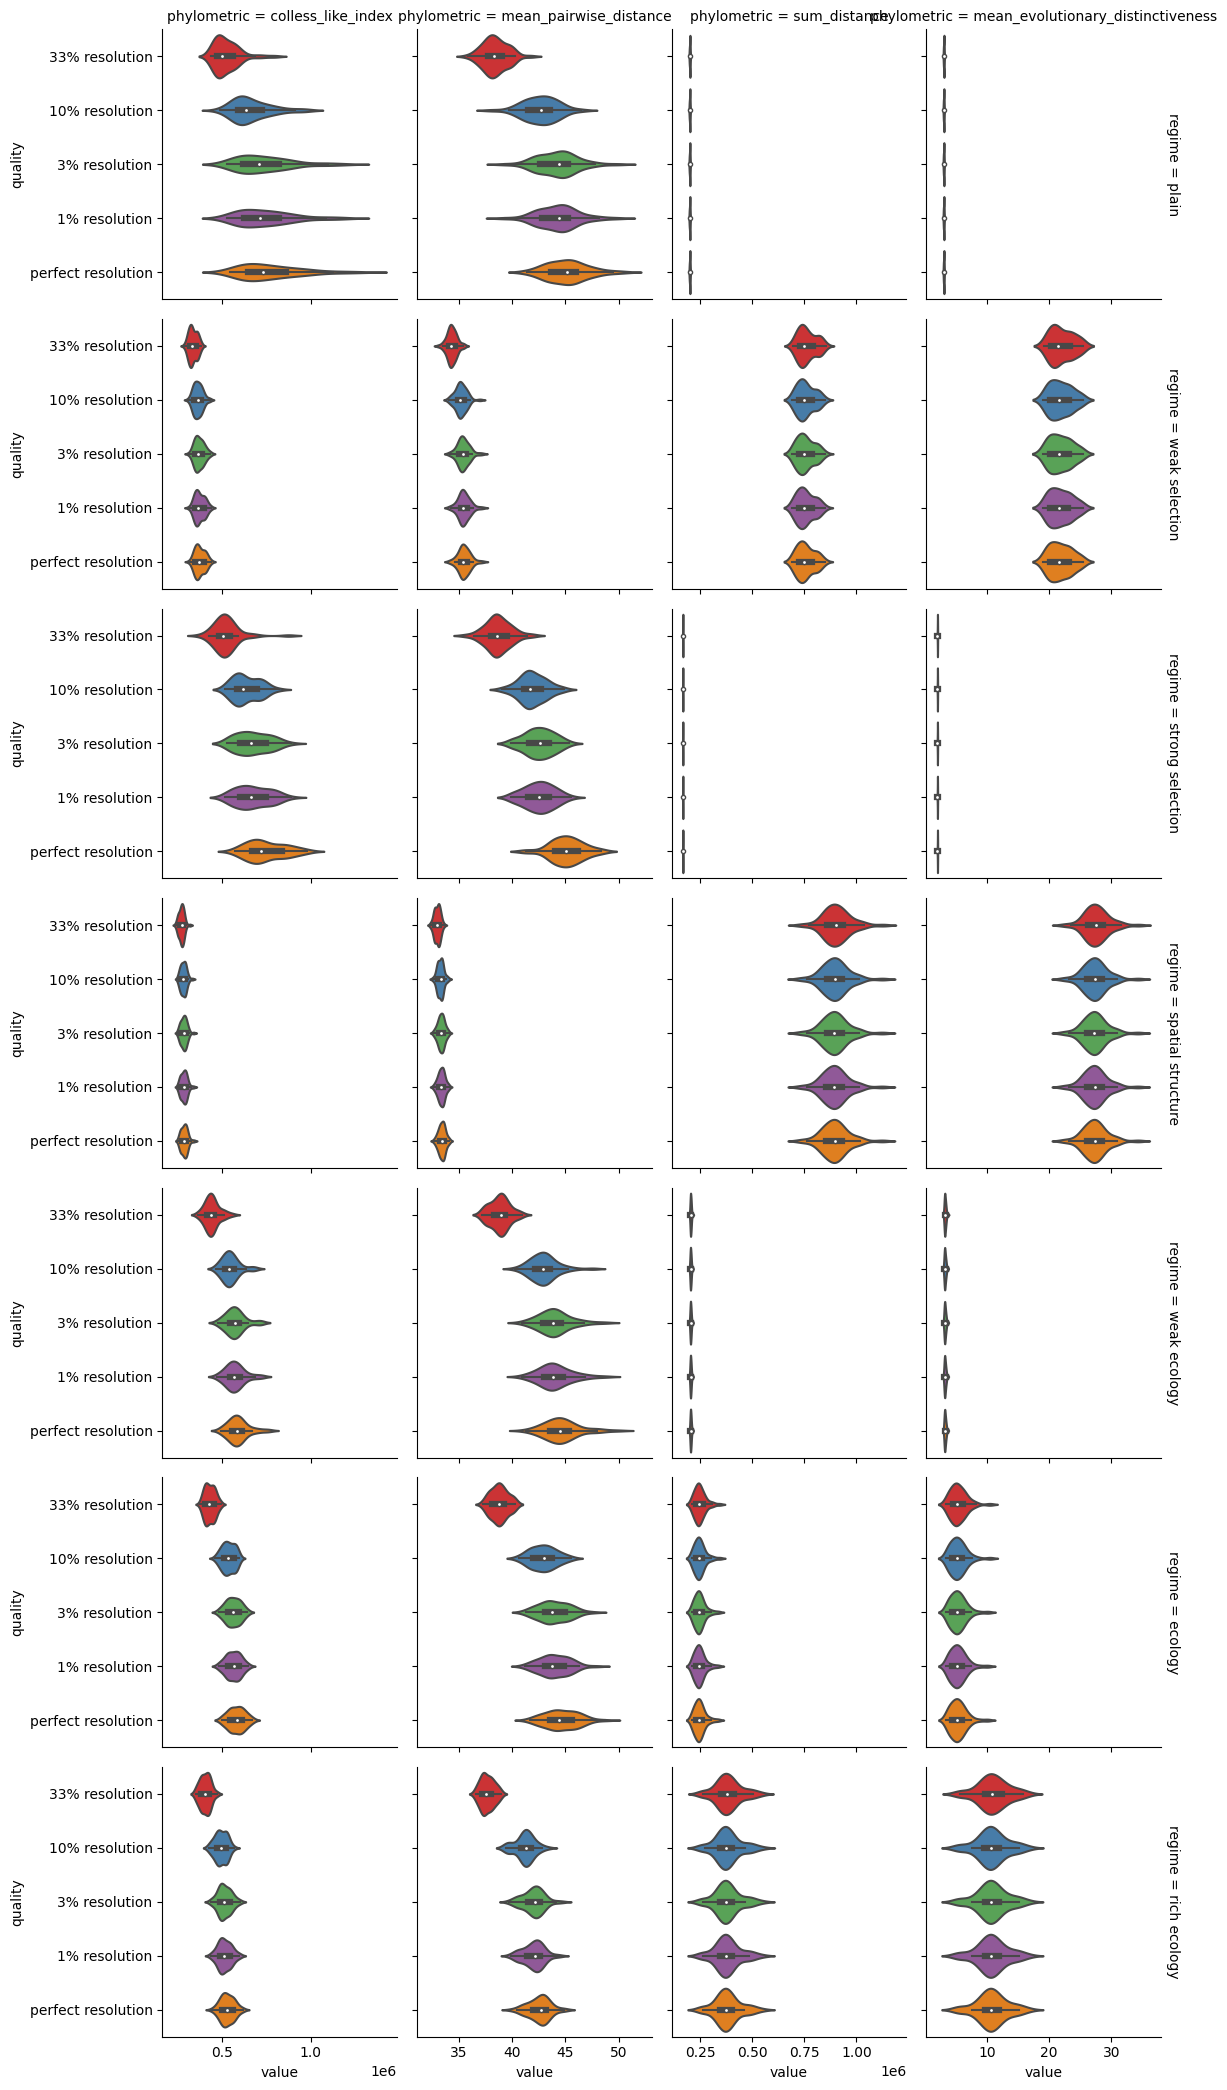

teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential+row=regime+viz=violinplot+x=value+y=quality+ext=.png


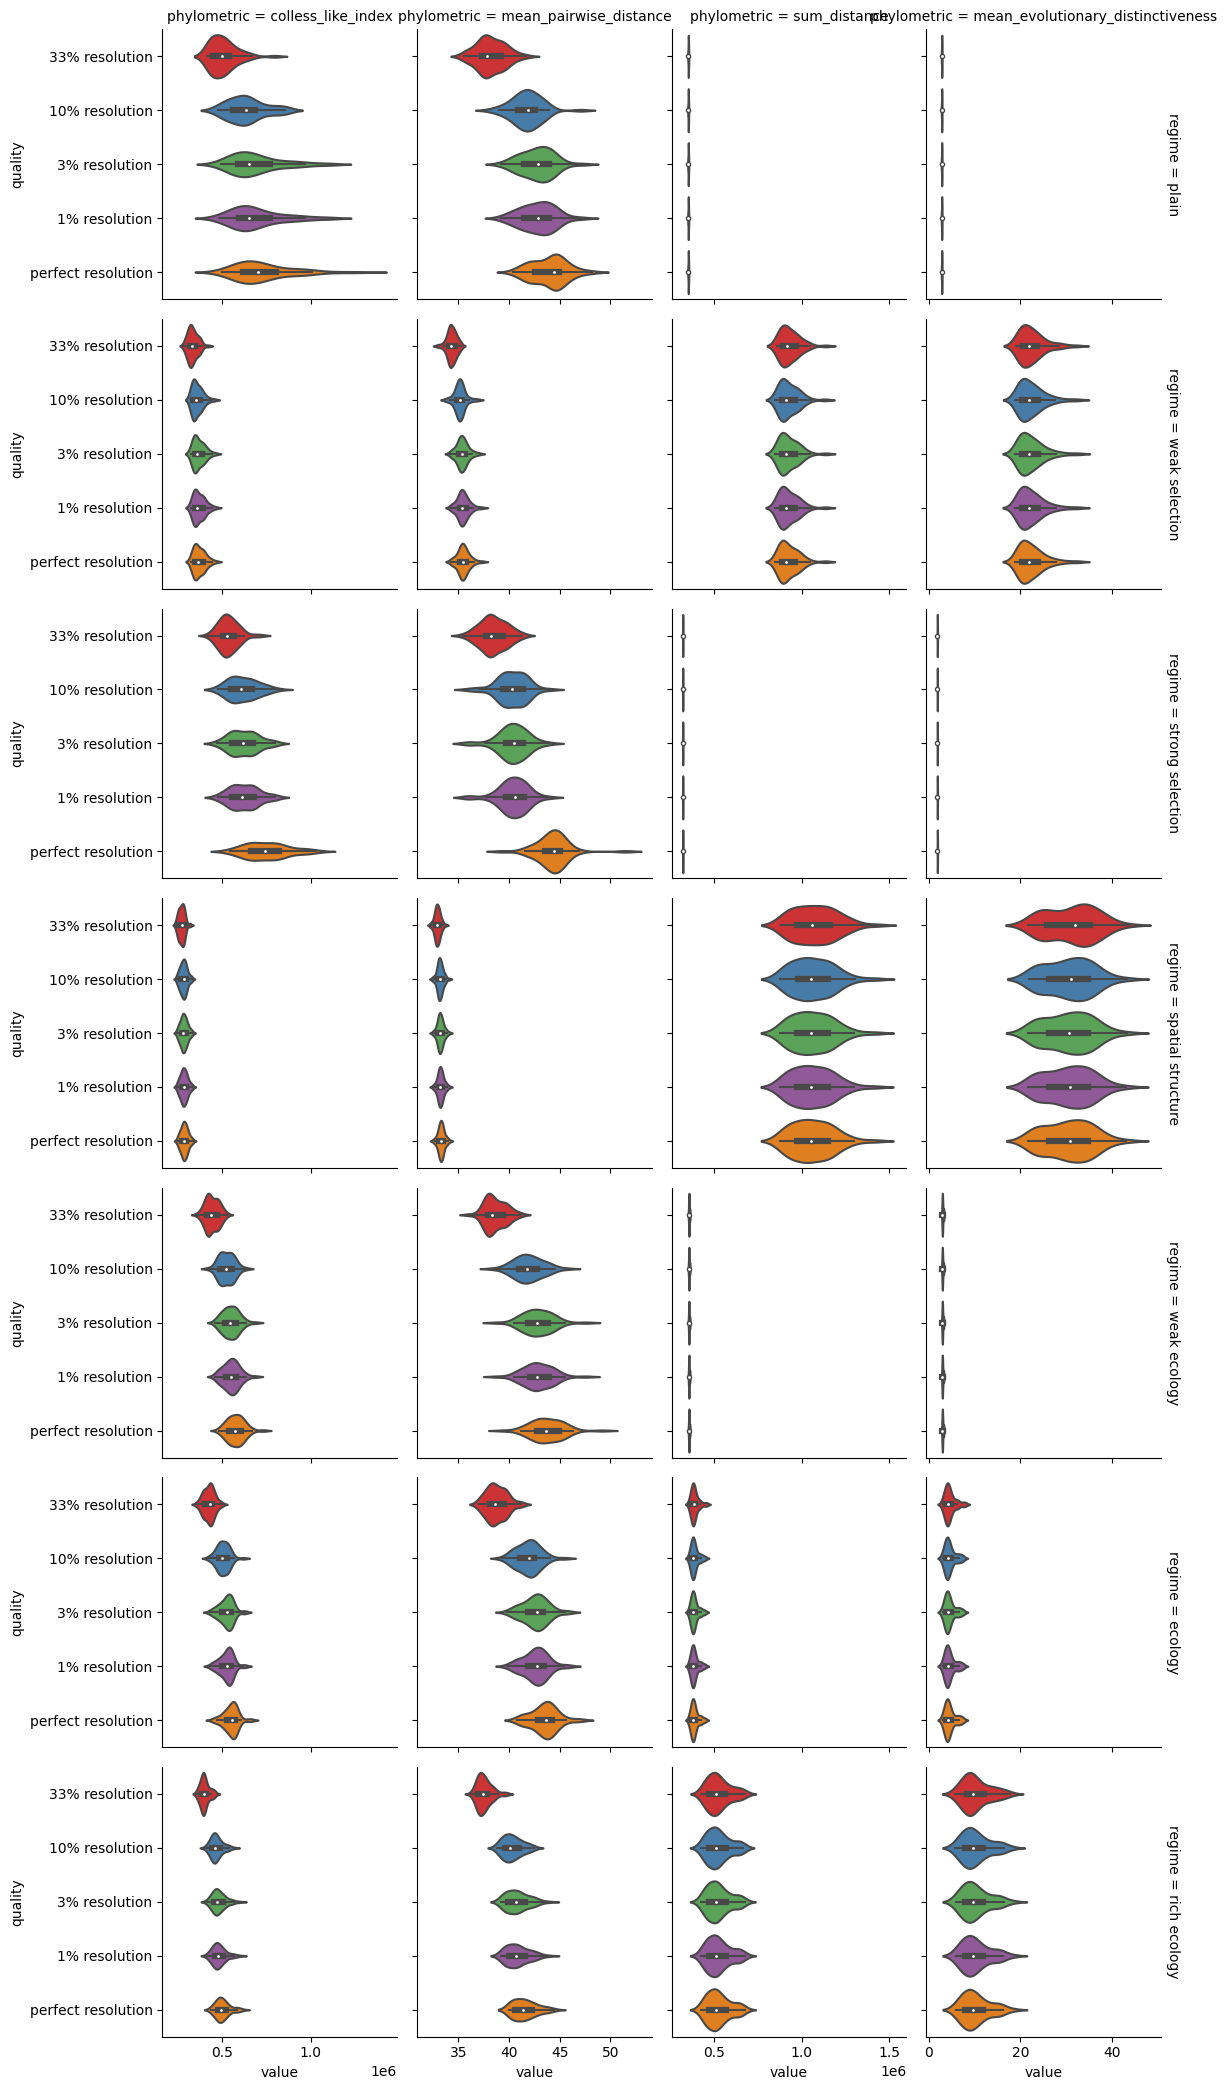

teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+row=regime+viz=violinplot+x=value+y=quality+ext=.pdf


teeplots/col=phylometric+epoch=7+mut_distn=np.random.standard_normal+row=regime+viz=violinplot+x=value+y=quality+ext=.png


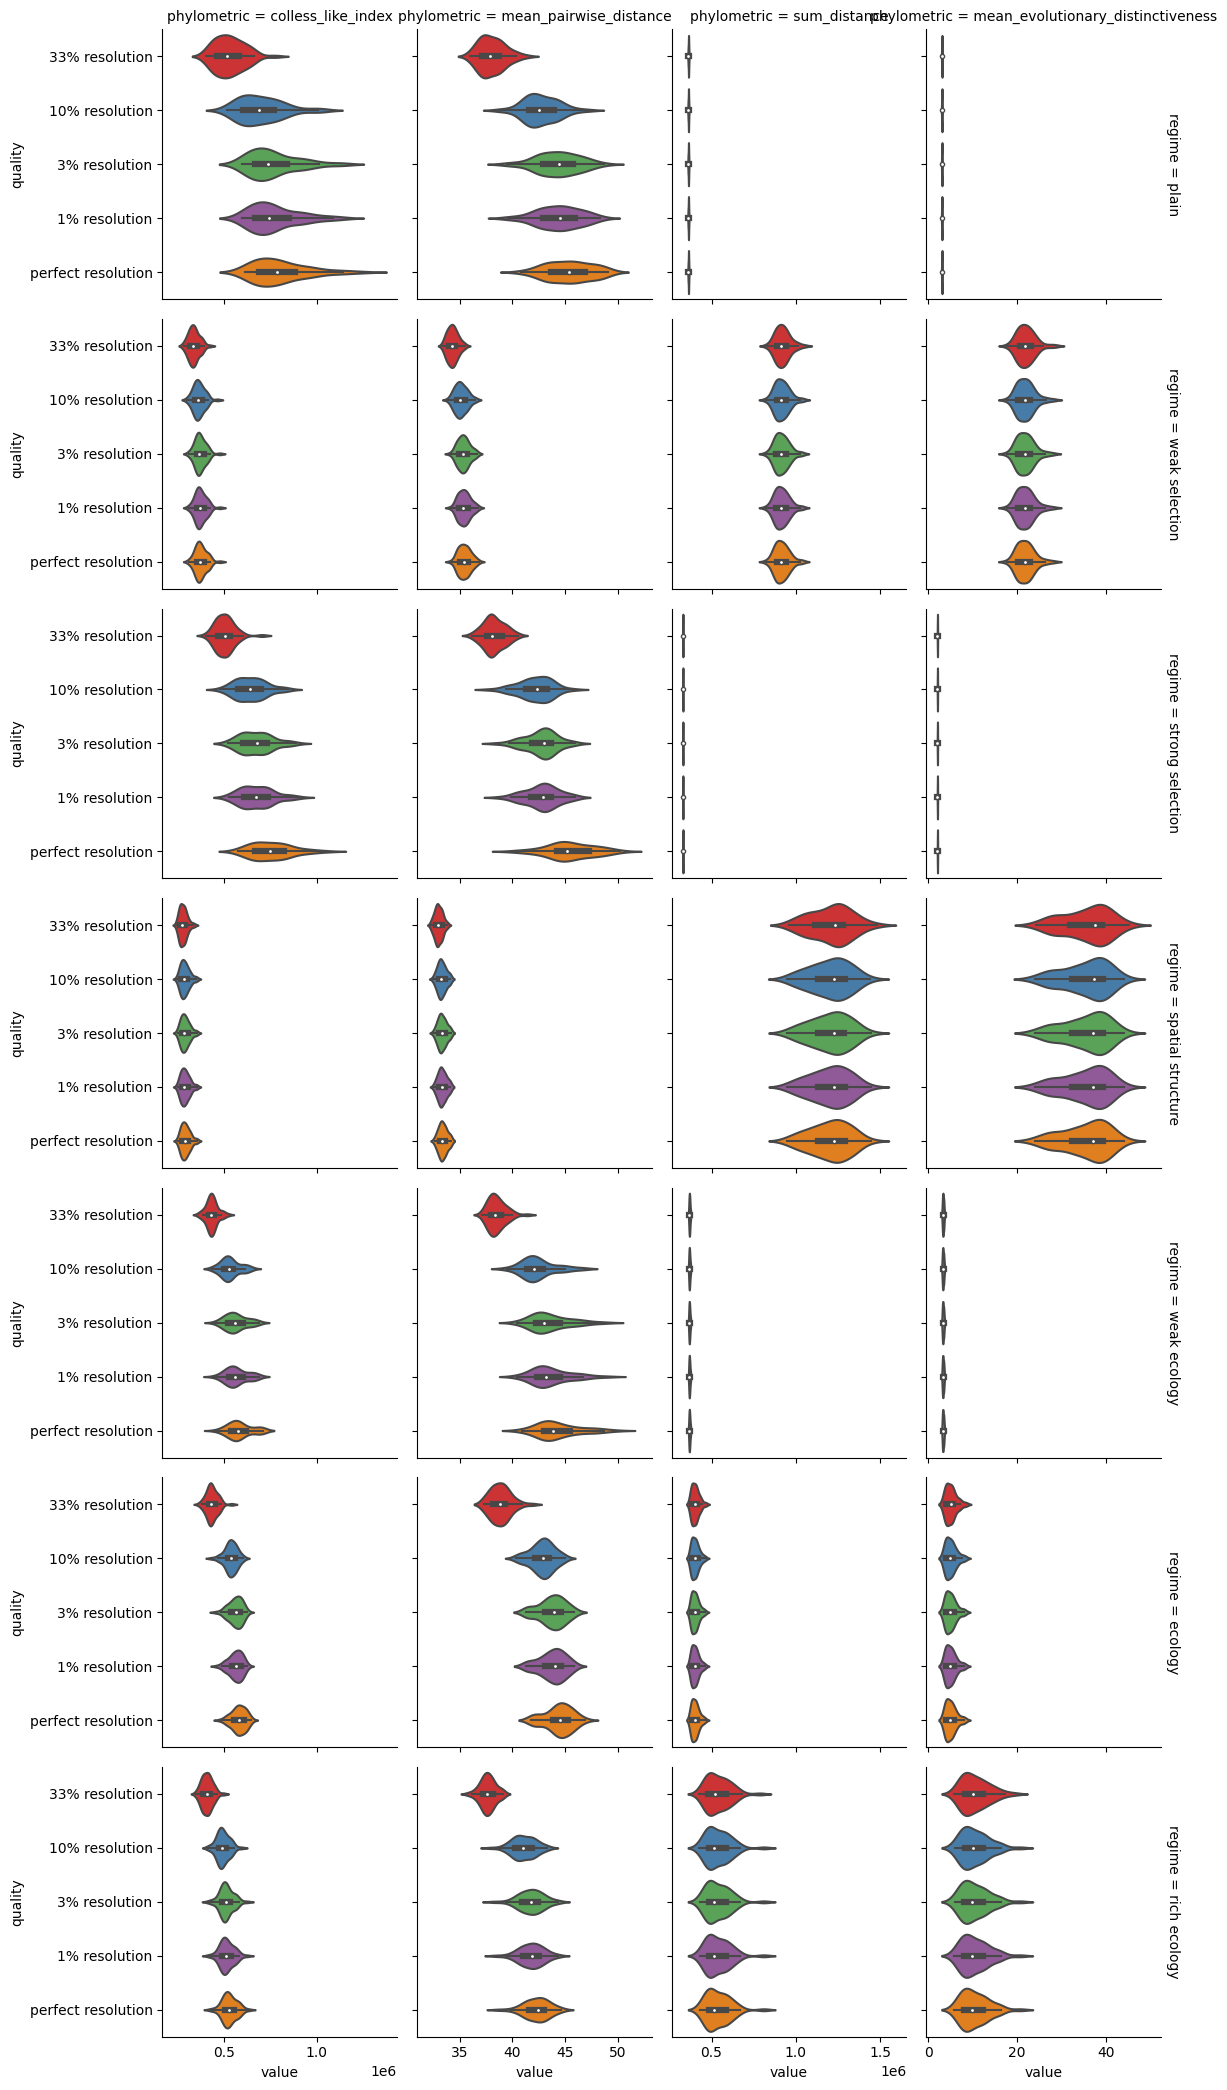

In [21]:
def make_do_plot(plotter):
    def do_plot(data, col, row, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            row=row,
            row_order=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak ecology",
                "ecology",
                "rich ecology",
            ],
            sharex="col",
            margin_titles=True,
        )
        g.map(
            plotter,
            x,
            y,
            order=[
                "33% resolution",
                "10% resolution",
                "3% resolution",
                "1% resolution",
                "perfect resolution",
            ],
            palette=sns.color_palette("Set1", 5),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        row="regime",
        x="value",
        y="quality",
        teeplot_outattrs=dict(
            zip(sensitivity_analysis_variables, group),
        ),
    )


# regime heatmap signatures

cliff's delta


teeplots/epoch=0+mut_distn=np.random.exponential+resolution=3.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/epoch=0+mut_distn=np.random.exponential+resolution=3.0+viz=heatmap+x=regime+y=phylometric+ext=.png


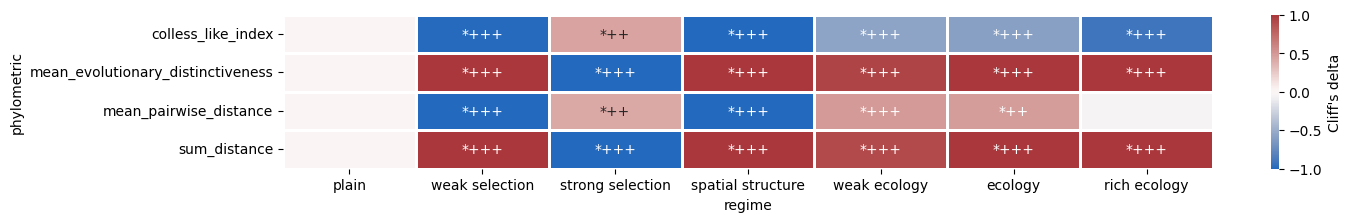

teeplots/epoch=0+mut_distn=np.random.exponential+resolution=10.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/epoch=0+mut_distn=np.random.exponential+resolution=10.0+viz=heatmap+x=regime+y=phylometric+ext=.png


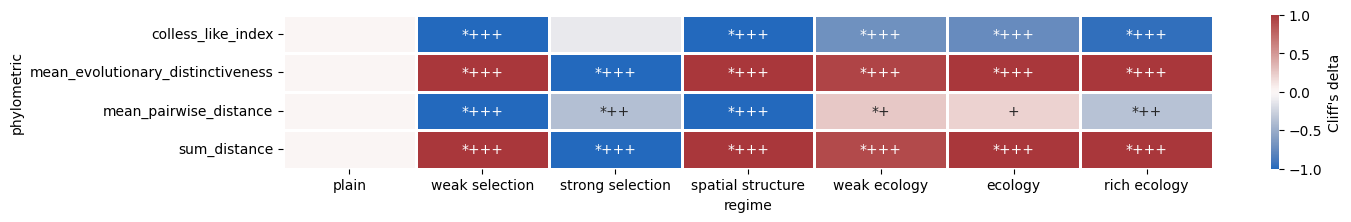

teeplots/epoch=0+mut_distn=np.random.exponential+resolution=30.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+mut_distn=np.random.exponential+resolution=30.0+viz=heatmap+x=regime+y=phylometric+ext=.png


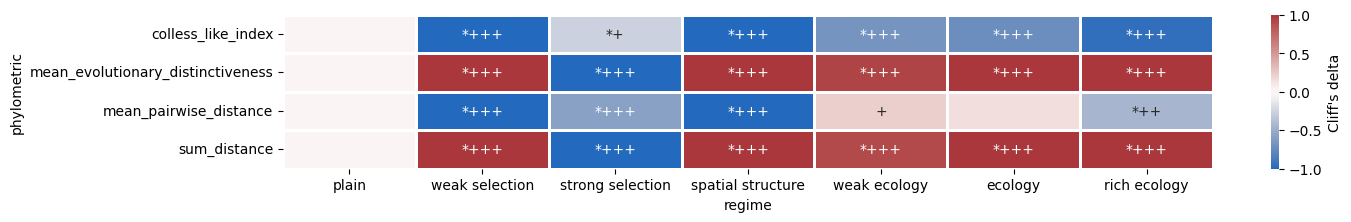

teeplots/epoch=0+mut_distn=np.random.exponential+resolution=100.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/epoch=0+mut_distn=np.random.exponential+resolution=100.0+viz=heatmap+x=regime+y=phylometric+ext=.png


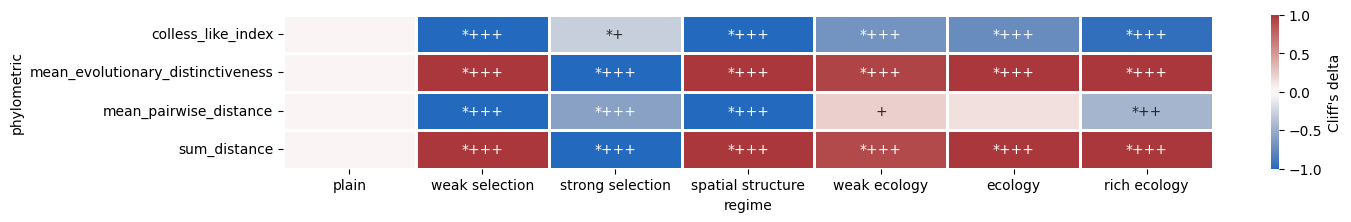

teeplots/epoch=0+mut_distn=np.random.standard_normal+resolution=3.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/epoch=0+mut_distn=np.random.standard_normal+resolution=3.0+viz=heatmap+x=regime+y=phylometric+ext=.png


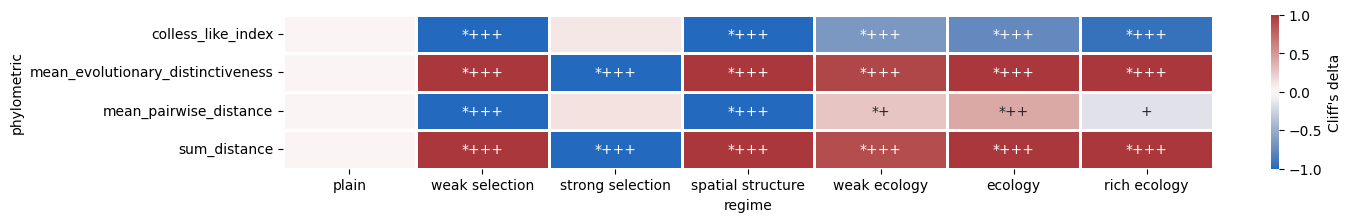

teeplots/epoch=0+mut_distn=np.random.standard_normal+resolution=10.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+mut_distn=np.random.standard_normal+resolution=10.0+viz=heatmap+x=regime+y=phylometric+ext=.png


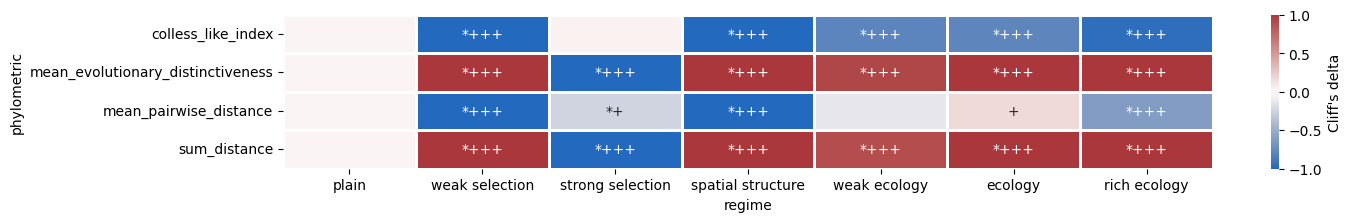

teeplots/epoch=0+mut_distn=np.random.standard_normal+resolution=30.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/epoch=0+mut_distn=np.random.standard_normal+resolution=30.0+viz=heatmap+x=regime+y=phylometric+ext=.png


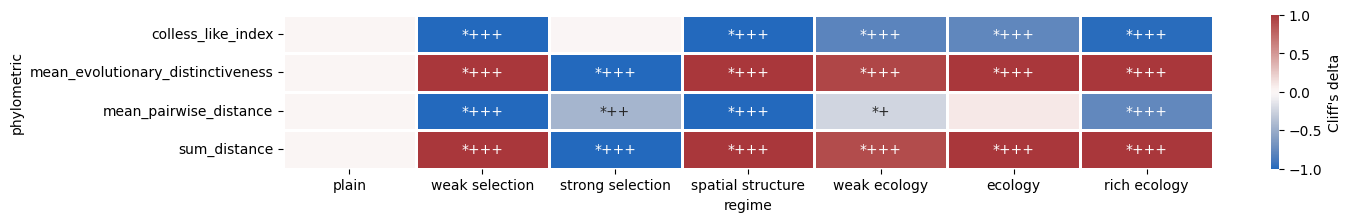

teeplots/epoch=0+mut_distn=np.random.standard_normal+resolution=100.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/epoch=0+mut_distn=np.random.standard_normal+resolution=100.0+viz=heatmap+x=regime+y=phylometric+ext=.png


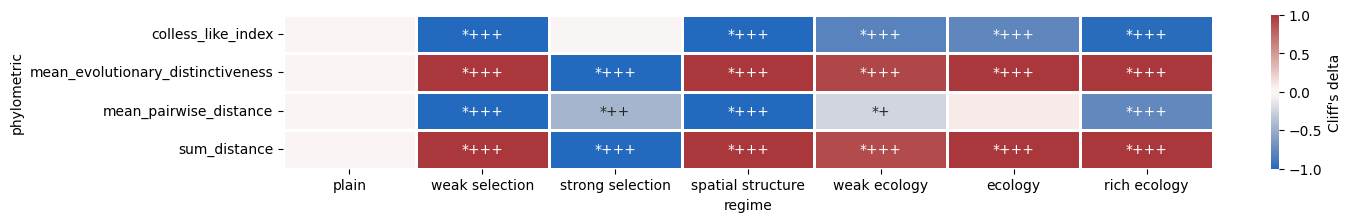

teeplots/epoch=2+mut_distn=np.random.exponential+resolution=3.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.exponential+resolution=3.0+viz=heatmap+x=regime+y=phylometric+ext=.png


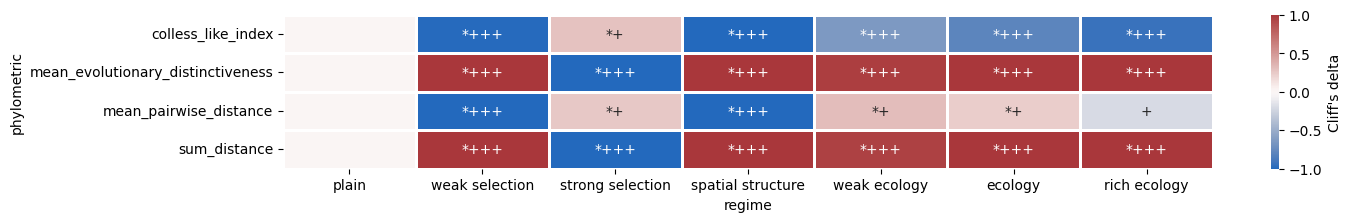

teeplots/epoch=2+mut_distn=np.random.exponential+resolution=10.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.exponential+resolution=10.0+viz=heatmap+x=regime+y=phylometric+ext=.png


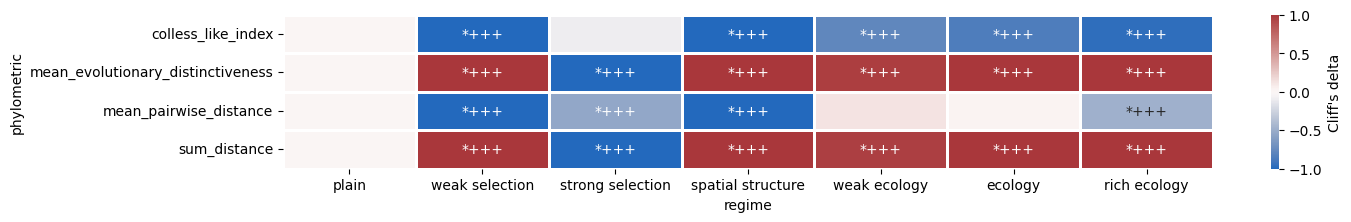

teeplots/epoch=2+mut_distn=np.random.exponential+resolution=30.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.exponential+resolution=30.0+viz=heatmap+x=regime+y=phylometric+ext=.png


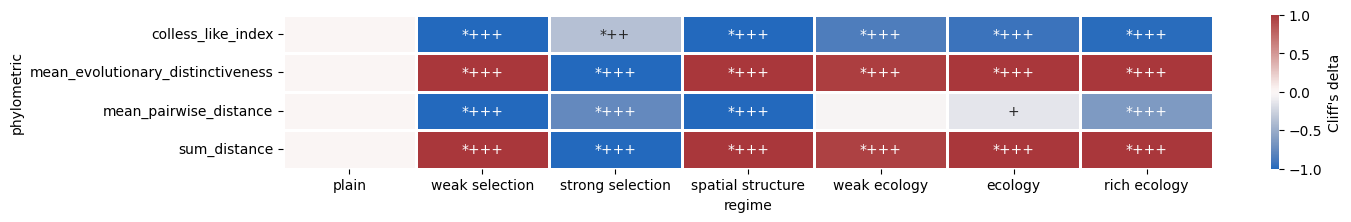

teeplots/epoch=2+mut_distn=np.random.exponential+resolution=100.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.exponential+resolution=100.0+viz=heatmap+x=regime+y=phylometric+ext=.png


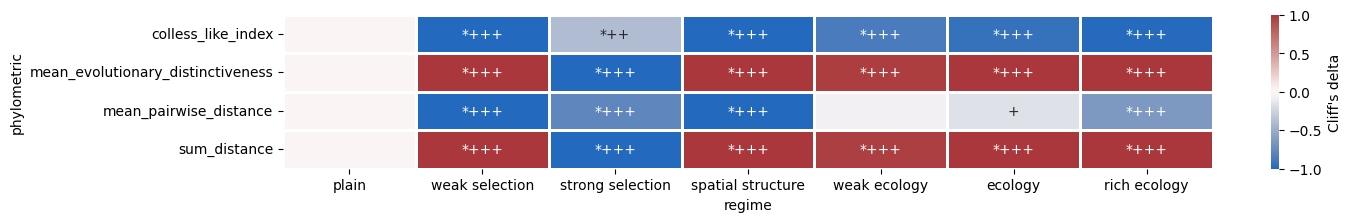

teeplots/epoch=2+mut_distn=np.random.standard_normal+resolution=3.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.standard_normal+resolution=3.0+viz=heatmap+x=regime+y=phylometric+ext=.png


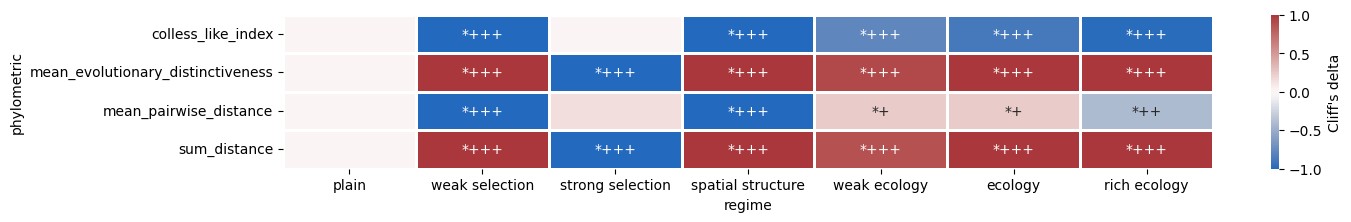

teeplots/epoch=2+mut_distn=np.random.standard_normal+resolution=10.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.standard_normal+resolution=10.0+viz=heatmap+x=regime+y=phylometric+ext=.png


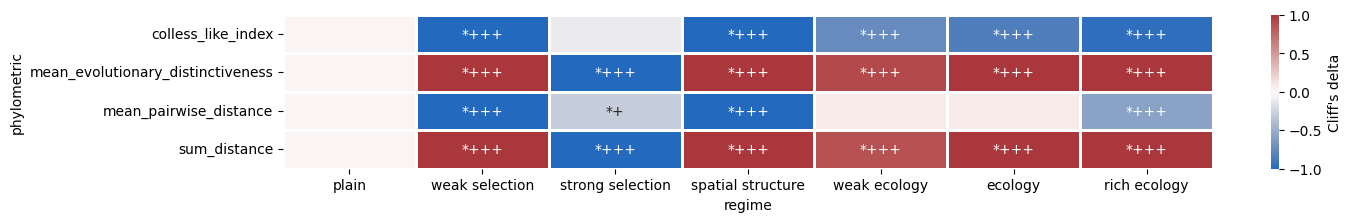

teeplots/epoch=2+mut_distn=np.random.standard_normal+resolution=30.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.standard_normal+resolution=30.0+viz=heatmap+x=regime+y=phylometric+ext=.png


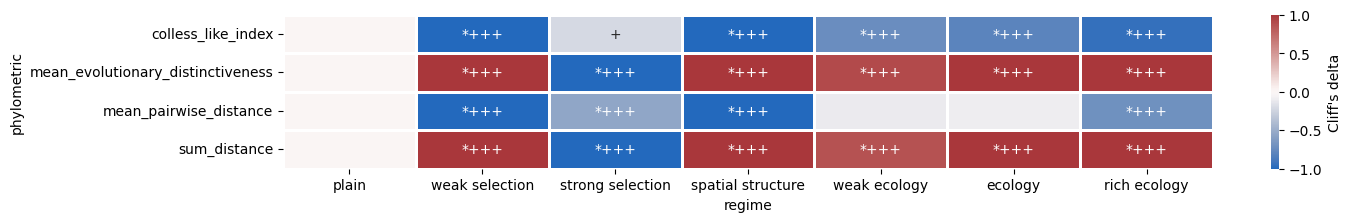

teeplots/epoch=2+mut_distn=np.random.standard_normal+resolution=100.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+mut_distn=np.random.standard_normal+resolution=100.0+viz=heatmap+x=regime+y=phylometric+ext=.png


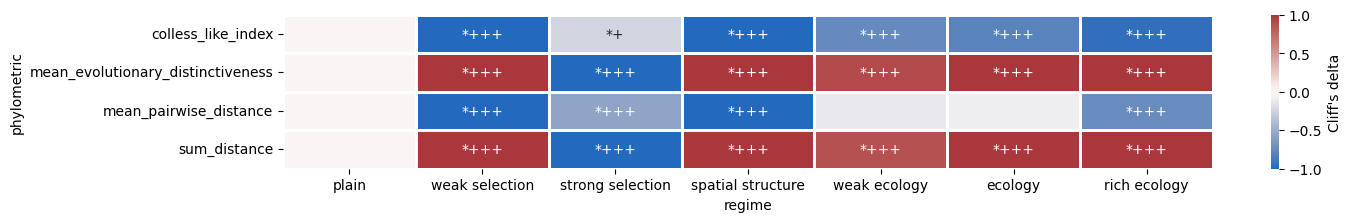

teeplots/epoch=7+mut_distn=np.random.exponential+resolution=3.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.exponential+resolution=3.0+viz=heatmap+x=regime+y=phylometric+ext=.png


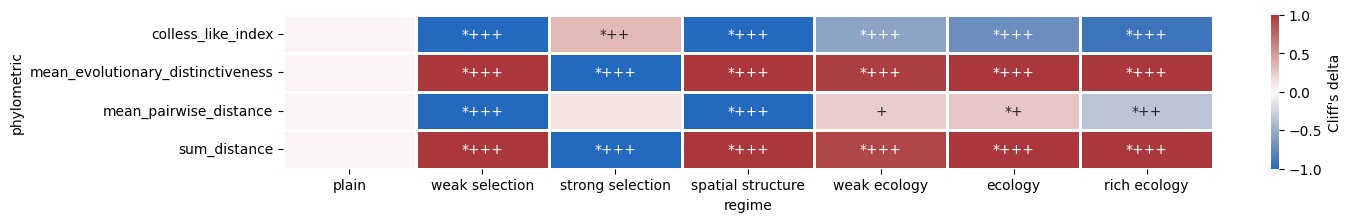

teeplots/epoch=7+mut_distn=np.random.exponential+resolution=10.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.exponential+resolution=10.0+viz=heatmap+x=regime+y=phylometric+ext=.png


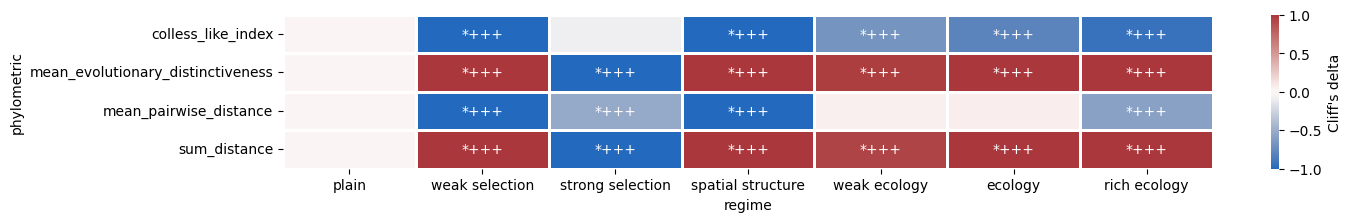

teeplots/epoch=7+mut_distn=np.random.exponential+resolution=30.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.exponential+resolution=30.0+viz=heatmap+x=regime+y=phylometric+ext=.png


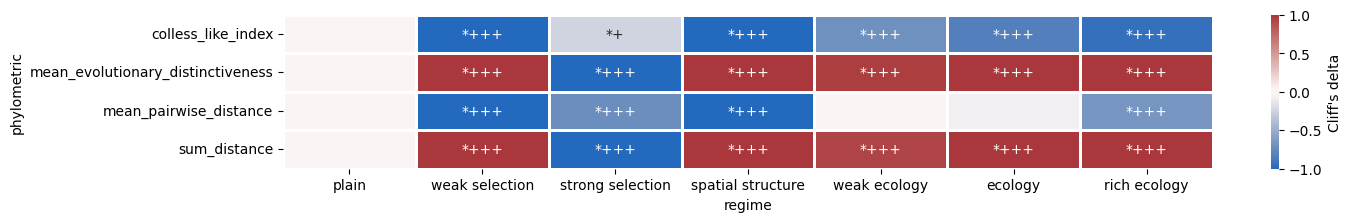

teeplots/epoch=7+mut_distn=np.random.exponential+resolution=100.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.exponential+resolution=100.0+viz=heatmap+x=regime+y=phylometric+ext=.png


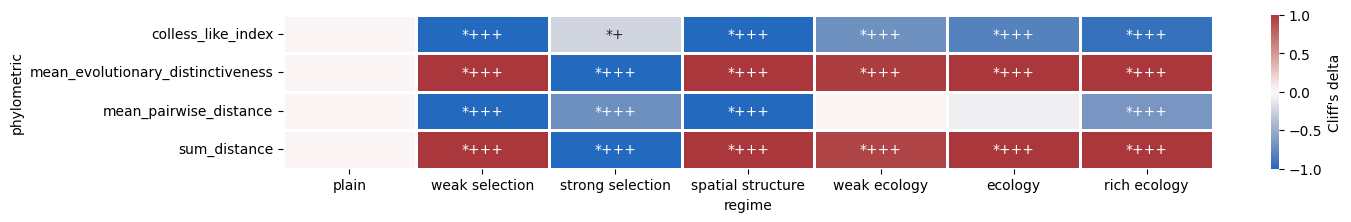

teeplots/epoch=7+mut_distn=np.random.standard_normal+resolution=3.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.standard_normal+resolution=3.0+viz=heatmap+x=regime+y=phylometric+ext=.png


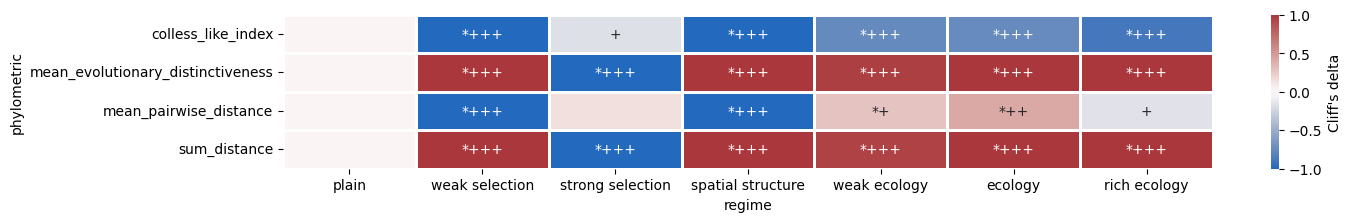

teeplots/epoch=7+mut_distn=np.random.standard_normal+resolution=10.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.standard_normal+resolution=10.0+viz=heatmap+x=regime+y=phylometric+ext=.png


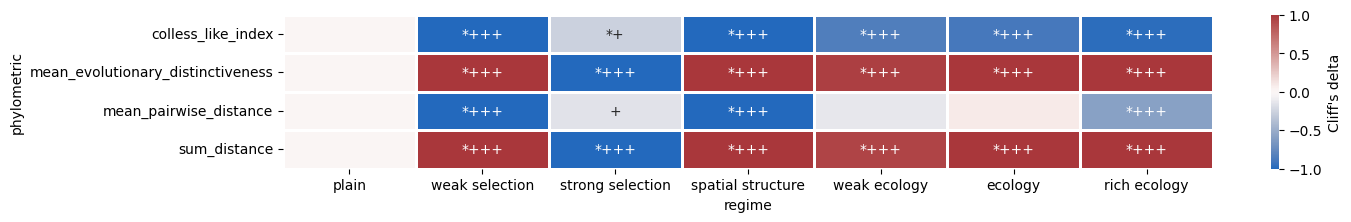

teeplots/epoch=7+mut_distn=np.random.standard_normal+resolution=30.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.standard_normal+resolution=30.0+viz=heatmap+x=regime+y=phylometric+ext=.png


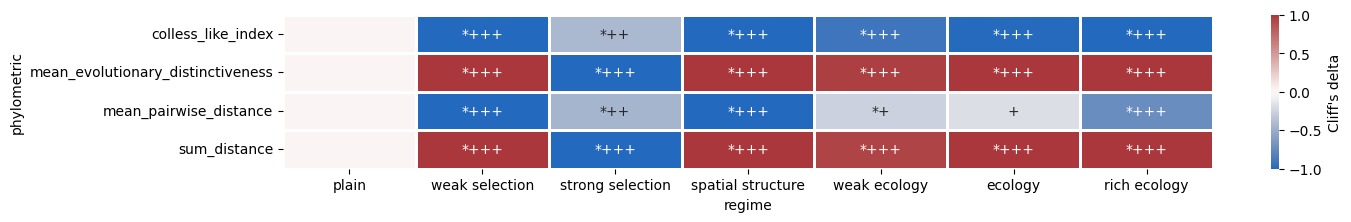

teeplots/epoch=7+mut_distn=np.random.standard_normal+resolution=100.0+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+mut_distn=np.random.standard_normal+resolution=100.0+viz=heatmap+x=regime+y=phylometric+ext=.png


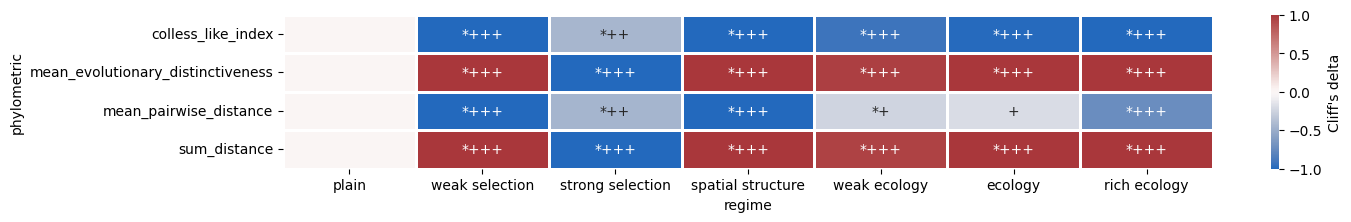

In [22]:
group_variables = sensitivity_analysis_variables + ["resolution"]
for (group, group_df) in df.groupby(
    group_variables,
):

    fil = (
        group_df[group_df["a"] == "reconstructed-tree"]
        .copy()
        .dropna(subset=["regime"])
    )

    melted_df = fil.melt(
        id_vars=["regime"],
        value_vars=phylometrics,
    )
    melted_df["phylometric"] = melted_df["variable"]

    def calc_cliffs_delta(group) -> float:
        phylometric, regime = group.name
        return -cliffs_delta(
            fil[fil["regime"] == "plain"][phylometric],
            fil[fil["regime"] == regime][phylometric],
        )[0]

    melted_df = melted_df.groupby(["phylometric", "regime"]).apply(
        calc_cliffs_delta,
    ).reset_index(name="value")

    fig, ax = plt.subplots(figsize=(15, 2))

    matrix = melted_df.pivot(
        index="phylometric",
        columns="regime",
        values="value",
    )
    matrix = matrix[
        sorted(
            matrix.columns,
            key=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak ecology",
                "ecology",
                "rich ecology",
            ].index,
        )
    ]

    annot = []
    for metric, row in matrix.iterrows():

        def getvec(regime: str) -> np.array:
            return fil[fil["regime"] == regime][metric].to_numpy()

        annot.append(
            [
                describe_effect(getvec("plain"), getvec(regime))
                for regime in matrix.columns
            ],
        )

    tp.tee(
        sns.heatmap,
        matrix,
        annot=annot,
        fmt="",
        linewidths=2,
        cmap=sns.color_palette("vlag", as_cmap=True),
        center=0,
        cbar_kws={"label": "Cliff's delta"},
        teeplot_outattrs={
            **dict(
                zip(group_variables, group),
            ),
            **{
                "x": "regime",
                "y": "phylometric",
            },
        },
        teeplot_outexclude=["fmt"],
        vmin=-1,
        vmax=1,
    )


# stats: comparison against perfect quality


In [23]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        ["regime", *sensitivity_analysis_variables], as_index=False
    ):
        for quality in group_df["quality"].unique():
            if quality == "perfect resolution":
                continue
            kw_result, n = scipy_stats.wilcoxon(
                group_df[group_df["quality"] == "perfect resolution"][
                    phylometric
                ],
                group_df[group_df["quality"] == quality][phylometric],
            ), ip.pophomogeneous(group_df.groupby(["quality"]).count()["a"])
            records.append(
                {
                    **{"quality": quality, "n": n, "phylometric": phylometric},
                    **dict(zip(["statistic", "p"], kw_result)),
                    **dict(
                        zip(["regime", *sensitivity_analysis_variables], group)
                    ),
                }
            )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            [*sensitivity_analysis_variables, "regime", "phylometric"],
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-resolutions-allpairs-wilcox+ext=.csv",
        index=False,
    )


quality   n                        phylometric  statistic  \
0     1% resolution  50                 colless_like_index      368.0   
1    33% resolution  50                 colless_like_index        0.0   
2    10% resolution  50                 colless_like_index      154.0   
3     3% resolution  50                 colless_like_index      337.0   
4     1% resolution  50  mean_evolutionary_distinctiveness      633.0   
5    33% resolution  50  mean_evolutionary_distinctiveness      621.0   
6    10% resolution  50  mean_evolutionary_distinctiveness      629.0   
7     3% resolution  50  mean_evolutionary_distinctiveness      599.0   
8     1% resolution  50             mean_pairwise_distance      378.0   
9    33% resolution  50             mean_pairwise_distance        0.0   
10   10% resolution  50             mean_pairwise_distance      149.0   
11    3% resolution  50             mean_pairwise_distance      334.0   
12    1% resolution  50                       sum_distance      625.0   
13   33% resolution  50                       sum_distance      621.0   
14   10% resolution  50                       sum_distance      637.0   
15    3% resolution  50                       sum_distance      606.0   
16   10% resolution  50                 colless_like_index      298.0   
17    1% resolution  50                 colless_like_index      465.0   
18    3% resolution  50                 colless_like_index      486.0   
19   33% resolution  50                 colless_like_index       25.0   
20   10% resolution  50  mean_evolutionary_distinctiveness      538.0   
21    1% resolution  50  mean_evolutionary_distinctiveness      598.0   
22    3% resolution  50  mean_evolutionary_distinctiveness      564.0   
23   33% resolution  50  mean_evolutionary_distinctiveness      588.0   
24   10% resolution  50             mean_pairwise_distance      129.0   
25    1% resolution  50             mean_pairwise_distance      297.0   
26    3% resolution  50             mean_pairwise_distance      302.0   
27   33% resolution  50             mean_pairwise_distance        0.0   
28   10% resolution  50                       sum_distance      532.0   
29    1% resolution  50                       sum_distance      593.0   
30    3% resolution  50                       sum_distance      564.0   
31   33% resolution  50                       sum_distance      599.0   
32   10% resolution  50                 colless_like_index      154.0   
33    1% resolution  50                 colless_like_index      267.0   
34    3% resolution  50                 colless_like_index      296.0   
35   33% resolution  50                 colless_like_index        0.0   
36   10% resolution  50  mean_evolutionary_distinctiveness      630.0   
37    1% resolution  50  mean_evolutionary_distinctiveness      606.0   
38    3% resolution  50  mean_evolutionary_distinctiveness      637.0   
39   33% resolution  50  mean_evolutionary_distinctiveness      609.0   
40   10% resolution  50             mean_pairwise_distance      120.0   
41    1% resolution  50             mean_pairwise_distance      285.0   
42    3% resolution  50             mean_pairwise_distance      323.0   
43   33% resolution  50             mean_pairwise_distance        0.0   
44   10% resolution  50                       sum_distance      630.0   
45    1% resolution  50                       sum_distance      605.0   
46    3% resolution  50                       sum_distance      637.0   
47   33% resolution  50                       sum_distance      609.0   
48   33% resolution  50                 colless_like_index      420.0   
49   10% resolution  50                 colless_like_index      499.0   
50    3% resolution  50                 colless_like_index      513.0   
51    1% resolution  50                 colless_like_index      626.0   
52   33% resolution  50  mean_evolutionary_distinctiveness      556.0   
53   10% resolution  50  mean_evolutionary_distinctiveness      634.0 

teeplots/epoch=0+hue=quality-threshold+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+hue=quality-threshold+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.png


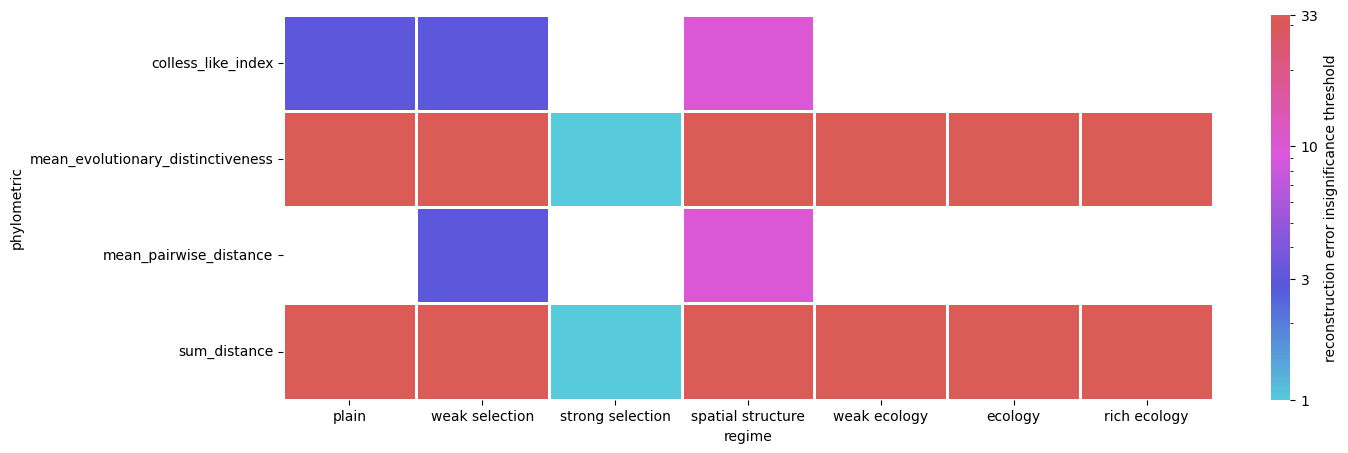

teeplots/epoch=0+hue=quality-threshold+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+hue=quality-threshold+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.png


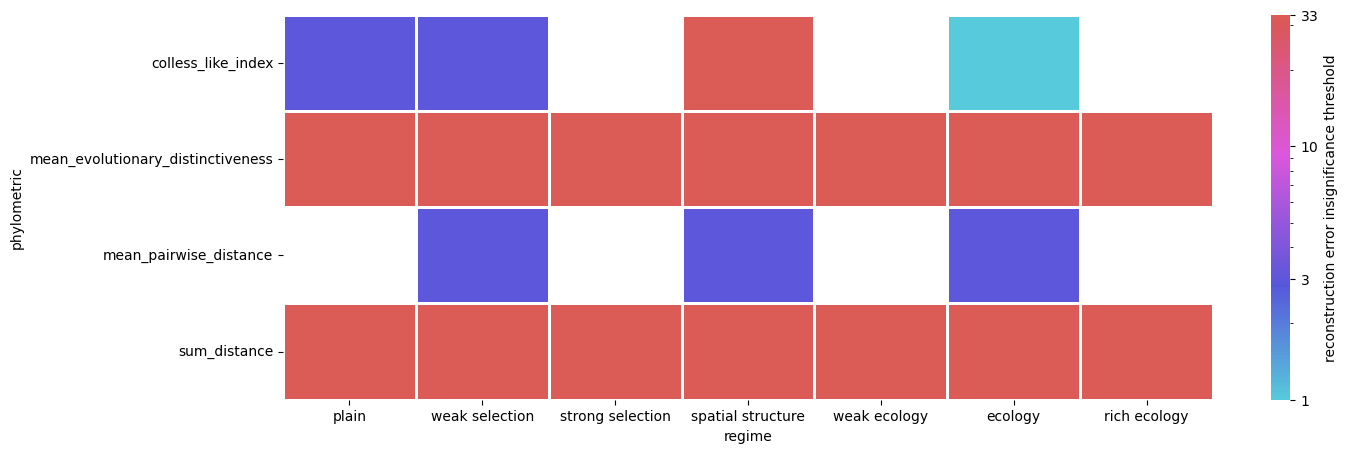

teeplots/epoch=2+hue=quality-threshold+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+hue=quality-threshold+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.png


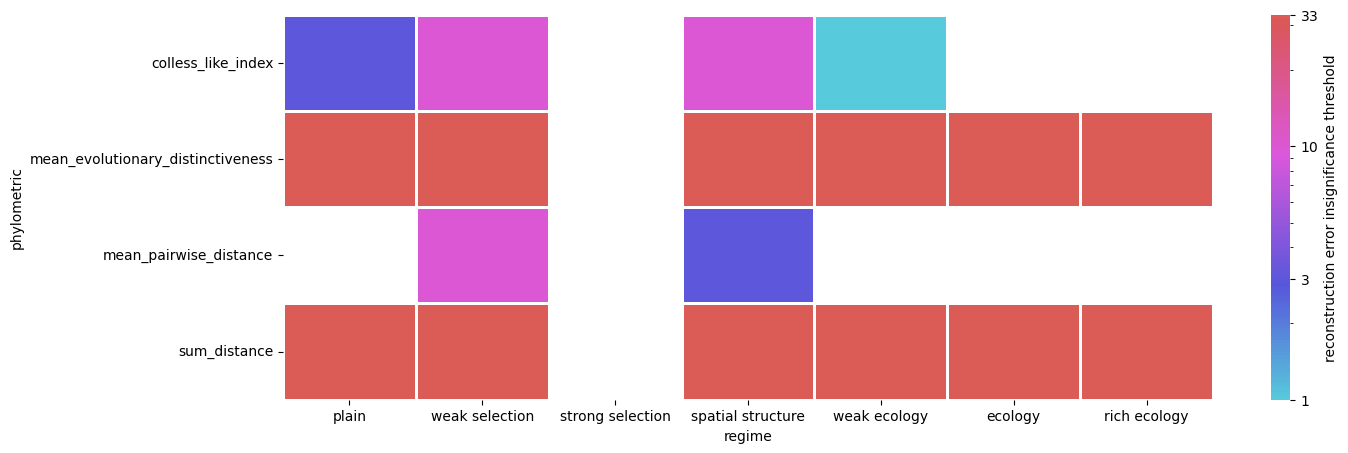

teeplots/epoch=2+hue=quality-threshold+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=2+hue=quality-threshold+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.png


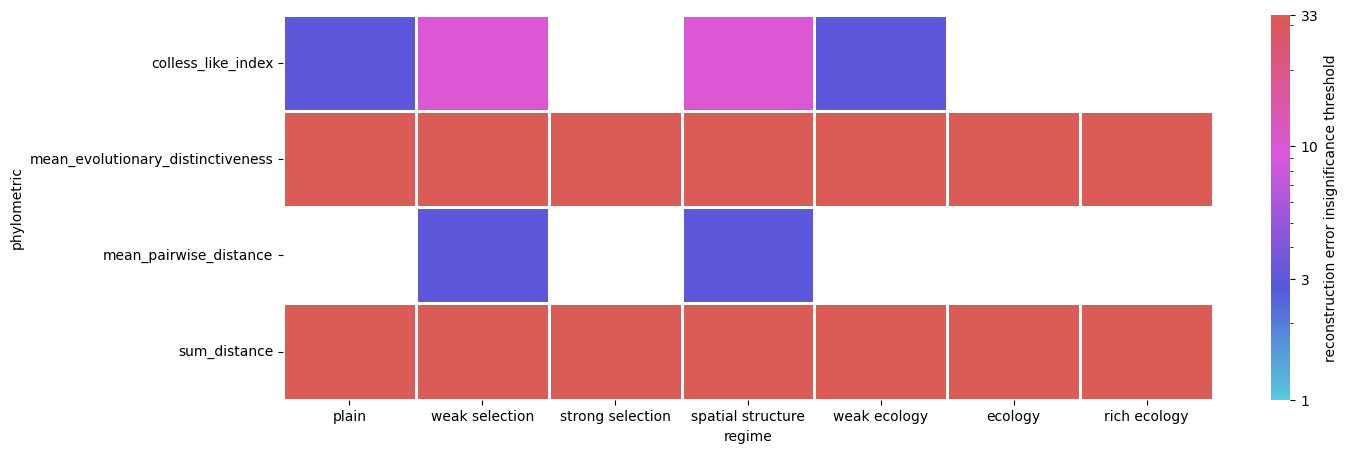

teeplots/epoch=7+hue=quality-threshold+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+hue=quality-threshold+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.png


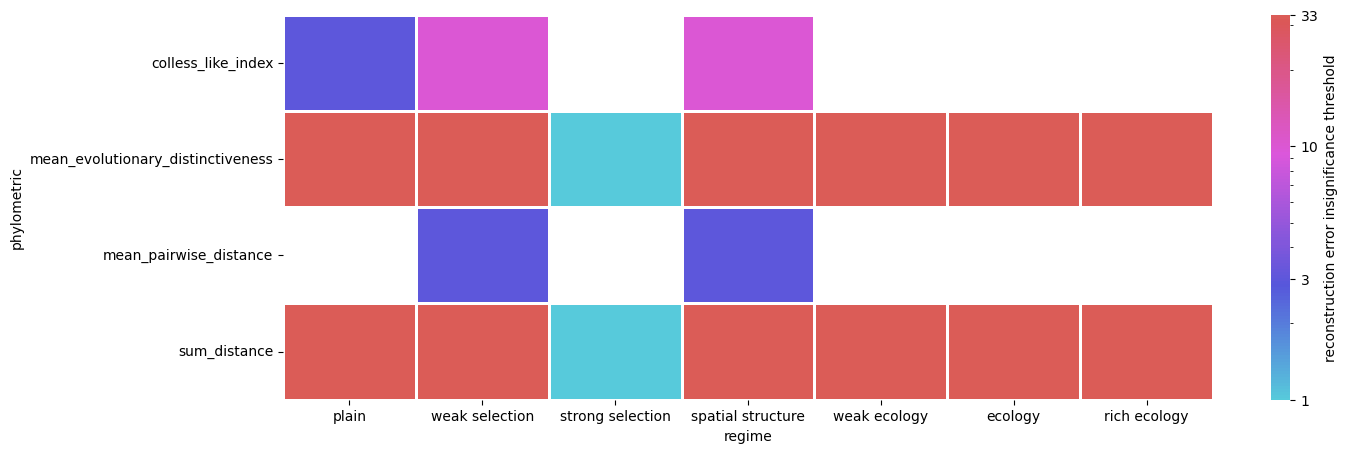

teeplots/epoch=7+hue=quality-threshold+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=7+hue=quality-threshold+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.png


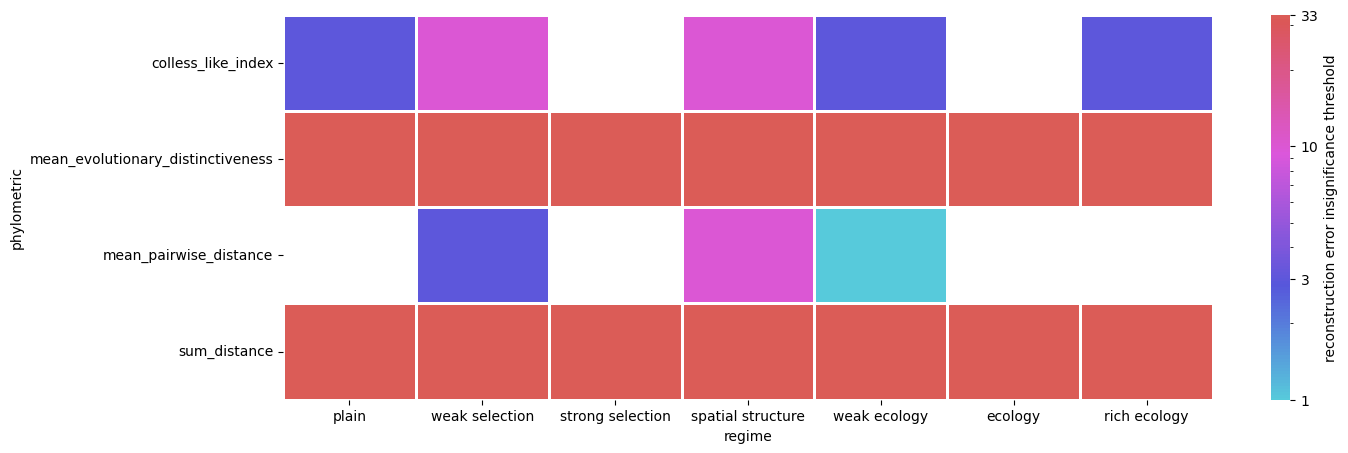

regime                        phylometric  quality threshold  \
0             ecology                 colless_like_index                NaN   
1             ecology  mean_evolutionary_distinctiveness               33.0   
2             ecology             mean_pairwise_distance                NaN   
3             ecology                       sum_distance               33.0   
4               plain                 colless_like_index                3.0   
5               plain  mean_evolutionary_distinctiveness               33.0   
6               plain             mean_pairwise_distance                NaN   
7               plain                       sum_distance               33.0   
8        rich ecology                 colless_like_index                3.0   
9        rich ecology  mean_evolutionary_distinctiveness               33.0   
10       rich ecology             mean_pairwise_distance                NaN   
11       rich ecology                       sum_distance               33.0   
12  spatial structure                 colless_like_index               10.0   
13  spatial structure  mean_evolutionary_distinctiveness               33.0   
14  spatial structure             mean_pairwise_distance               10.0   
15  spatial structure                       sum_distance               33.0   
16   strong selection                 colless_like_index                NaN   
17   strong selection  mean_evolutionary_distinctiveness               33.0   
18   strong selection             mean_pairwise_distance                NaN   
19   strong selection                       sum_distance               33.0   
20       weak ecology                 colless_like_index                3.0   
21       weak ecology  mean_evolutionary_distinctiveness               33.0   
22       weak ecology             mean_pairwise_distance                1.0   
23       weak ecology                       sum_distance               33.0   
24     weak selection                 colless_like_index               10.0   
25     weak selection  mean_evolutionary_distinctiveness               33.0   
26     weak selection             mean_pairwise_distance                3.0   
27     weak selection                       sum_distance               33.0   

    epoch                  mut_distn  
0       7  np.random.standard_normal  
1       7  np.random.standard_normal  
2       7  np.random.standard_normal  
3       7  np.random.standard_normal  
4       7  np.random.standard_normal  
5       7  np.random.standard_normal  
6       7  np.random.standard_normal  
7       7  np.random.standard_normal  
8       7  np.random.standard_normal  
9       7  np.random.standard_normal  
10      7  np.random.standard_normal  
11      7  np.random.standard_normal  
12      7  np.random.standard_normal  
13      7  np.random.standard_normal  
14      7  np.random.standard_normal  
15      7  np.random.standard_normal  
16      7  np.random.standard_normal  
17      7  np.random.standard_normal  
18      7  np.random.standard_normal  
19      7  np.random.standard_normal  
20      7  np.random.standard_normal  
21      7  np.random.standard_normal  
22      7  np.random.standard_normal  
23      7  np.random.standard_normal  
24      7  np.random.standard_normal  
25      7  np.random.standard_normal  
26      7  np.random.standard_normal  
27      7  np.random.standard_normal

In [24]:
for group, group_df in out_df.groupby(
    sensitivity_analysis_variables, as_index=False
):
    group_df["quality threshold"] = group_df["quality"]
    group_df.loc[group_df["p"] > 0.05, "quality threshold"] = ""
    summarized_df = (
        group_df.groupby(["regime", "phylometric"])
        .agg(
            {
                "quality threshold": lambda subgroup: (
                    np.nan
                    if "1% resolution" in set(subgroup)
                    else 1
                    if "3% resolution" in set(subgroup)
                    else 3
                    if "10% resolution" in set(subgroup)
                    else 10
                    if "33% resolution" in set(subgroup)
                    else 33
                ),
                "epoch": lambda subgroup: ip.pophomogeneous(subgroup),
                "mut_distn": lambda subgroup: ip.pophomogeneous(subgroup),
            }
        )
        .reset_index()
    )

    matrix = summarized_df.pivot(
        index="phylometric",
        columns="regime",
        values="quality threshold",
    )
    matrix = matrix[
        sorted(
            matrix.columns,
            key=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak ecology",
                "ecology",
                "rich ecology",
            ].index,
        )
    ]

    fig, ax = plt.subplots(figsize=(15, 5))
    formatter = mpl.ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)
    tp.tee(
        sns.heatmap,
        matrix,
        linewidths=2,
        norm=mpl.colors.LogNorm(vmin=1, vmax=33),
        cmap=sns.color_palette("hls", as_cmap=True),
        center=0,
        cbar_kws={
            "label": "reconstruction error insignificance threshold",
            "ticks": [1, 3, 10, 33],
            "format": formatter,
        },
        teeplot_outattrs={
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
            **{
                "hue": "quality-threshold",
                "x": "regime",
                "y": "phylometric",
            },
        },
        vmin=1,
        vmax=33,
    )

summarized_df
